In [1]:
# Install a pip package in the current Jupyter kernel
import sys
#!{sys.executable} -m pip install mne-connectivity

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import gc
from glob import glob
import numpy as np
import scipy as sp
import statistics, math
import random as rd
import pandas as pd
import dataframe_image as dfi
pd.options.display.float_format = '{:,.2f}'.format

from math import sqrt, ceil

from sklearn import metrics, svm
from sklearn import decomposition, cluster
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, 
                             balanced_accuracy_score, precision_score, recall_score, RocCurveDisplay)
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

from scipy.spatial.distance import correlation
from IPython.display import display

In [4]:
import mne
#import mne_connectivity

from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap, annotate_muscle_zscore, peak_finder,
                               find_eog_events, find_ecg_events, ica_find_ecg_events, find_bad_channels_maxwell)
from mne.time_frequency import (tfr_array_multitaper, psd_array_multitaper, csd_array_multitaper, csd_array_morlet)

from mne_connectivity import seed_target_indices, spectral_connectivity_epochs, spectral_connectivity_time

print(mne.__file__)
print(mne.__version__)

C:\Users\Lenovo\anaconda3\lib\site-packages\mne\__init__.py
1.3.1


In [5]:
import plotly.graph_objects as go
from gtda.time_series import SingleTakensEmbedding, TakensEmbedding, takens_embedding_optimal_parameters
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import BettiCurve, Scaler, Filtering, Amplitude, PersistenceEntropy, NumberOfPoints
from gtda.plotting import plot_point_cloud


In [6]:
# Configure the graphics engine

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.rc('figure', max_open_warning=200)
%matplotlib notebook
#%matplotlib inline
#%matplotlib qt

In [7]:
import seaborn as sns
# Apply the default theme
sns.set_theme()

In [8]:
# My modules
import my_varexplore as ve
import my_dimreduct as dr
import my_clustquality as cq
import my_stageprocess as spr

## Clustering functions

In [9]:
# Функция для расчёта оценок качетва кластеризации
def cluster_metrics_noground(name, data, labels_pred):
    results = [name]
    df_data = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])

    # Define the metrics which require only data and predicted labels
    cluster_metrics = [
        metrics.silhouette_score,
        metrics.calinski_harabasz_score,
        metrics.davies_bouldin_score
    ]
    results += [m(data, labels_pred) for m in cluster_metrics]

    df_data.loc[0] = results
    
    return df_data

In [10]:
def apply_cluster_method(data, cl_method, name, df_metrics, **kwargs):
    method = cl_method(**kwargs).fit(data)
    
    df = cluster_metrics_noground(name, data, method.labels_)
    df_metrics = df_metrics.drop(df_metrics[df_metrics['Method']==name].index, errors='ignore')
    df_metrics = pd.concat([df_metrics, df], ignore_index=True)
    
    return method, df_metrics

In [11]:
# Calculating clustering noground metrics for adjacent pairs of stages (Silh, Cal-Har, Dav-Bold)
def calc_stage_metr_noground(df_features, st_edges):
    df_metrics = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])
    
    for _st in range(1, len(st_edges)-1):
        name = 'St'+str(_st)+'_St'+str(_st+1)
        data = df_features.iloc[st_edges[_st-1]:st_edges[_st+1]].reset_index(drop=True)
        labels = [0 for i in range(st_edges[_st]-st_edges[_st-1])] + [1 for i in range(st_edges[_st+1]-st_edges[_st])]
        
        df = cq.cluster_metrics_noground(name, data, labels)
        df_metrics = df_metrics.drop(df_metrics[df_metrics['Method']==name].index, errors='ignore')
        df_metrics = pd.concat([df_metrics, df], ignore_index=True)
    
    df_metrics.rename(columns={'Method': 'Stages'}, inplace=True)

    return df_metrics


In [12]:
# Матрица связности для k соседних по времени эпох
#K_NEIGHBORS = 30

def knn_con_matr(X):
    n_samples = len(X)
    sm = sp.sparse.lil_matrix((n_samples, n_samples), dtype=np.int8)
    for i in range(n_samples):
        for j in range(n_samples):
            if abs(i-j)<=k_neighbours: sm[i,j]=1
    return sm.tocsr()


# Loading data

In [13]:
#==============================================
# Input main data information
#==============================================

# Number of the subject for analysis
SUBJ_NUM = 3

# For m1 and m3 suffix for EEG record number 
#SUFFIX = '' # for m10 & m8
SUFFIX = '_2' # for m3 (2nd meditation)


In [14]:
# Initialize path variables for main folders

print(os.getcwd())

if (SUBJ_NUM < 10):
    subj_dir_name = 'm0' + str(SUBJ_NUM) + SUFFIX
else:
    subj_dir_name = 'm' + str(SUBJ_NUM) + SUFFIX

# Add suffix _surr for surrogate data to destination folder
subj_dir_name_stg = subj_dir_name + '_stg'
    
# Path for loading EEG raw data
init_dir_path = os.path.join(os.getcwd(), 'work_data')

# Path for loading raw data and stage boundaries
ft_dir_path = os.path.join(os.getcwd(), 'features', subj_dir_name)

print(init_dir_path)
print(ft_dir_path)


C:\Users\Lenovo\PycharmProjects\Tibet
C:\Users\Lenovo\PycharmProjects\Tibet\work_data
C:\Users\Lenovo\PycharmProjects\Tibet\features\m03_2


In [15]:
# Loading epochs (Meditator data)

epochs_filt_rr = mne.read_epochs(os.path.join(ft_dir_path, 'epochs_filt_rr-epo.fif'))
#epochs_filt_rr = epochs_filt_rr[:-2] # for m8 (artifacts at the end)
print(epochs_filt_rr.get_data().shape)

sampling_rate = epochs_filt_rr.info['sfreq']
n_samples = epochs_filt_rr.__len__()
n_times = len(epochs_filt_rr.get_data()[0,0,:])
print(n_samples, n_times)

ch_names = epochs_filt_rr.ch_names
n_channels = len(ch_names)
print(ch_names)

Reading C:\Users\Lenovo\PycharmProjects\Tibet\features\m03_2\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1180 matching events found
No baseline correction applied
0 projection items activated
(1180, 40, 501)
1180 501
['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FT7', 'FC3', 'FCz', 'FC4', 'FT8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'A1', 'T5', 'P3', 'Pz', 'P4', 'T6', 'A2', 'P5', 'PO3', 'POz', 'PO4', 'P6', 'PO7', 'O1', 'Oz', 'O2', 'PO8']


In [16]:
# Loading main features DataFrames

df_ft_psd_loc_db = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_psd_loc_db.feather'))[:n_samples]
df_ft_psd_plt_db = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_psd_plt_db.feather'))[:n_samples]
df_ft_psd_all_db = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_psd_all_db.feather'))[:n_samples]
df_ft_psd_ind_loc_log = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_psd_ind_loc_log.feather'))[:n_samples]
df_ft_psd_ind_plt_log = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_psd_ind_plt_log.feather'))[:n_samples]
df_ft_psd_ind_all_log = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_psd_ind_all_log.feather'))[:n_samples]

#df_ft_coh = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_coh.feather'))
#df_ft_plv = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_plv.feather'))
df_ft_coh_loc = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_coh_loc.feather'))[:n_samples]
df_ft_plv_loc = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_plv_loc.feather'))[:n_samples]
df_ft_coh_plt = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_coh_plt.feather'))[:n_samples]
df_ft_plv_plt = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_plv_plt.feather'))[:n_samples]

df_ft_coh_ind_loc = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_coh_ind_loc.feather'))[:n_samples]
df_ft_plv_ind_loc = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_plv_ind_loc.feather'))[:n_samples]
df_ft_coh_ind_plt = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_coh_ind_plt.feather'))[:n_samples]
df_ft_plv_ind_plt = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_plv_ind_plt.feather'))[:n_samples]
df_ft_coh_ind_all = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_coh_ind_all.feather'))[:n_samples]
df_ft_plv_ind_all = pd.read_feather(os.path.join(ft_dir_path, 'df_ft_plv_ind_all.feather'))[:n_samples]

In [17]:
# Scaling features data

# PSD & PSD indices
ft_psd_loc_db_sc = StandardScaler().fit_transform(df_ft_psd_loc_db.to_numpy())
df_ft_psd_loc_db_sc = pd.DataFrame(ft_psd_loc_db_sc, columns=df_ft_psd_loc_db.columns)
ft_psd_all_db_sc = StandardScaler().fit_transform(df_ft_psd_all_db.to_numpy())
df_ft_psd_all_db_sc = pd.DataFrame(ft_psd_all_db_sc, columns=df_ft_psd_all_db.columns)

ft_psd_ind_loc_sc = StandardScaler().fit_transform(df_ft_psd_ind_loc_log.to_numpy())
df_ft_psd_ind_loc_sc = pd.DataFrame(ft_psd_ind_loc_sc, columns=df_ft_psd_ind_loc_log.columns)
ft_psd_ind_all_sc = StandardScaler().fit_transform(df_ft_psd_ind_all_log.to_numpy())
df_ft_psd_ind_all_sc = pd.DataFrame(ft_psd_ind_all_sc, columns=df_ft_psd_ind_all_log.columns)

# Coherence indices
ft_coh_ind_loc_sc = StandardScaler().fit_transform(df_ft_coh_ind_loc.to_numpy())
df_ft_coh_ind_loc_sc = pd.DataFrame(ft_coh_ind_loc_sc, columns=df_ft_coh_ind_loc.columns)

# PLV indices
ft_plv_ind_loc_sc = StandardScaler().fit_transform(df_ft_plv_ind_loc.to_numpy())
df_ft_plv_ind_loc_sc = pd.DataFrame(ft_plv_ind_loc_sc, columns=df_ft_plv_ind_loc.columns)


In [18]:
# Stage boundaries

st_edges_result = np.loadtxt(os.path.join(ft_dir_path, 'st_edges_result.txt'), dtype=int)
st_edges_res_samp = np.loadtxt(os.path.join(ft_dir_path, 'st_edges_res_samp.txt'), dtype=int)
print(st_edges_result)
print(st_edges_res_samp)

# Form stage bands and labels
st_bands, st_labels = spr.form_stage_bands(st_edges_result)
n_stages = len(st_bands)
print(st_bands)


[   0   83  133  261  458  685  783  938 1037 1126 1180]
[  4250  48750  75750 148250 258750 386250 439250 523750 577250 624250]
[(0, 82, 'St1'), (83, 132, 'St2'), (133, 260, 'St3'), (261, 457, 'St4'), (458, 684, 'St5'), (685, 782, 'St6'), (783, 937, 'St7'), (938, 1036, 'St8'), (1037, 1125, 'St9'), (1126, 1179, 'St10')]


In [200]:
# Loading shuffled stages results

st_edges_result = np.loadtxt(os.path.join(ft_dir_path, 'st_edges_result_stg.txt'), dtype=int) # Resulting stage boundaries
st_edges_init = np.loadtxt(os.path.join(ft_dir_path, 'st_edges_init_stg.txt'), dtype=int) # Initial stage boundaries
shuf_stages = np.loadtxt(os.path.join(ft_dir_path, 'shuffled_stages_order.txt'), dtype=int)  # Shuffling order

st_edges_all = np.loadtxt(os.path.join(ft_dir_path, 'st_edges_all_stg.txt'), dtype=int) # Goint array of potential boundaries
edg_labels_sort = np.loadtxt(os.path.join(ft_dir_path, 'edg_labels_sort_stg.txt'), dtype=int) # Cluster labels for goint array

n_stages = len(st_edges_result)-1
n_stages_init = len(st_edges_init)-1

# Construct shuffled epoch indices array
shuf_stage_ind = []
for _st in shuf_stages:
    (smin, smax, _) = st_bands[_st]
    st_ind = [i for i in range(smin, smax+1)]
    shuf_stage_ind += st_ind
print(n_stages, n_stages_init, len(shuf_stage_ind))
#print(shuf_stage_ind)
print()


11 10 1180



# Shuffling stages

In [19]:
# Shuffle raw data 

# Remember random seed
rnd_seed = rd.randint(0,100)
print(rnd_seed)
#rd.seed(rnd_seed)
#rd.seed(65) # for m10
#rd.seed(60) # for m8
rd.seed(16) # for m3

# Shuffle stage indices
shuf_stages = np.arange(n_stages)
rd.shuffle(shuf_stages)
print(shuf_stages)

st_names_init = ['St'+str(n+1) for n in shuf_stages]
print(st_names_init)

# Construct shuffled epoch indices array
shuf_stage_ind = []
for _st in shuf_stages:
    (smin, smax, _) = st_bands[_st]
    st_ind = [i for i in range(smin, smax+1)]
    shuf_stage_ind += st_ind
print(len(shuf_stage_ind))
#print(shuf_stage_ind)
print()

# Initial stage boundary array after shuffling stages
st_edges_init = [shuf_stage_ind.index(i) for i in st_edges_result[:-1]]
st_edges_init += [n_samples]
st_edges_init.sort()

print(st_edges_result)
print(st_edges_init)


90
[6 4 0 9 1 3 2 8 7 5]
['St7', 'St5', 'St1', 'St10', 'St2', 'St4', 'St3', 'St9', 'St8', 'St6']
1180

[   0   83  133  261  458  685  783  938 1037 1126 1180]
[0, 155, 382, 465, 519, 569, 766, 894, 983, 1082, 1180]


In [139]:
#rnd_seed = rd.randint(0,100)
#print(rnd_seed)

In [20]:
# Loading main features DataFrames

# Shuffling features for Surrogate data

df_ft_psd_loc_db_stg = df_ft_psd_loc_db.copy().iloc[shuf_stage_ind].reset_index(drop=True)
df_ft_psd_plt_db_stg = df_ft_psd_plt_db.copy().iloc[shuf_stage_ind].reset_index(drop=True)
df_ft_psd_all_db_stg = df_ft_psd_all_db.copy().iloc[shuf_stage_ind].reset_index(drop=True)
df_ft_psd_ind_loc_log_stg = df_ft_psd_ind_loc_log.copy().iloc[shuf_stage_ind].reset_index(drop=True)
df_ft_psd_ind_plt_log_stg = df_ft_psd_ind_plt_log.copy().iloc[shuf_stage_ind].reset_index(drop=True)
df_ft_psd_ind_all_log_stg = df_ft_psd_ind_all_log.copy().iloc[shuf_stage_ind].reset_index(drop=True)

df_ft_coh_loc_stg = df_ft_coh_loc.copy().iloc[shuf_stage_ind].reset_index(drop=True)
df_ft_plv_loc_stg = df_ft_plv_loc.copy().iloc[shuf_stage_ind].reset_index(drop=True)
df_ft_coh_plt_stg = df_ft_coh_plt.copy().iloc[shuf_stage_ind].reset_index(drop=True)
df_ft_plv_plt_stg = df_ft_plv_plt.copy().iloc[shuf_stage_ind].reset_index(drop=True)

df_ft_coh_ind_loc_stg = df_ft_coh_ind_loc.copy().iloc[shuf_stage_ind].reset_index(drop=True)
df_ft_plv_ind_loc_stg = df_ft_plv_ind_loc.copy().iloc[shuf_stage_ind].reset_index(drop=True)
df_ft_coh_ind_plt_stg = df_ft_coh_ind_plt.copy().iloc[shuf_stage_ind].reset_index(drop=True)
df_ft_plv_ind_plt_stg = df_ft_plv_ind_plt.copy().iloc[shuf_stage_ind].reset_index(drop=True)
df_ft_coh_ind_all_stg = df_ft_coh_ind_all.copy().iloc[shuf_stage_ind].reset_index(drop=True)
df_ft_plv_ind_all_stg = df_ft_plv_ind_all.copy().iloc[shuf_stage_ind].reset_index(drop=True)


In [21]:
# Scaling features data (Surrogate data)

# PSD & PSD indices
ft_psd_loc_db_sc_stg = StandardScaler().fit_transform(df_ft_psd_loc_db_stg.to_numpy())
df_ft_psd_loc_db_sc_stg = pd.DataFrame(ft_psd_loc_db_sc_stg, columns=df_ft_psd_loc_db_stg.columns)
ft_psd_all_db_sc_stg = StandardScaler().fit_transform(df_ft_psd_all_db_stg.to_numpy())
df_ft_psd_all_db_sc_stg = pd.DataFrame(ft_psd_all_db_sc_stg, columns=df_ft_psd_all_db_stg.columns)

ft_psd_ind_loc_sc_stg = StandardScaler().fit_transform(df_ft_psd_ind_loc_log_stg.to_numpy())
df_ft_psd_ind_loc_sc_stg = pd.DataFrame(ft_psd_ind_loc_sc_stg, columns=df_ft_psd_ind_loc_log_stg.columns)
ft_psd_ind_all_sc_stg = StandardScaler().fit_transform(df_ft_psd_ind_all_log_stg.to_numpy())
df_ft_psd_ind_all_sc_stg = pd.DataFrame(ft_psd_ind_all_sc_stg, columns=df_ft_psd_ind_all_log_stg.columns)

# Coherence indices
ft_coh_ind_loc_sc_stg = StandardScaler().fit_transform(df_ft_coh_ind_loc_stg.to_numpy())
df_ft_coh_ind_loc_sc_stg = pd.DataFrame(ft_coh_ind_loc_sc_stg, columns=df_ft_coh_ind_loc_stg.columns)

# PLV indices
ft_plv_ind_loc_sc_stg = StandardScaler().fit_transform(df_ft_plv_ind_loc_stg.to_numpy())
df_ft_plv_ind_loc_sc_stg = pd.DataFrame(ft_plv_ind_loc_sc_stg, columns=df_ft_plv_ind_loc_stg.columns)


# Testing

In [22]:
gc.collect()

53

## Unshuffled stages

In [26]:
# PCA decomposition

# Number of PCA compnents
#N_COMP = 0.7
N_COMP = 15

df_ft_tot_orig = pd.concat([df_ft_psd_loc_db_sc, df_ft_psd_ind_loc_sc, df_ft_coh_ind_loc_sc, 
                            df_ft_plv_ind_loc_sc], axis=1)
n_features = len(df_ft_tot_orig.columns)

pca = decomposition.PCA(n_components=N_COMP)

ft_tot_pca = pca.fit_transform(df_ft_tot_orig)
print(ft_tot_pca.shape)
print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
print([round(x,3) for x in pca.explained_variance_ratio_])


n_pca_comps = len(ft_tot_pca[0,:])
pca_comp_names = ['PCA_'+str(i) for i in range(n_pca_comps)]
#print(n_pca_comps)
print(n_features)
print(n_samples)

df_ft_tot_pca = pd.DataFrame()
df_ft_tot_pca = pd.DataFrame(ft_tot_pca, columns=pca_comp_names)
display(df_ft_tot_pca)

(1180, 15)
Explained variance 0.72
[0.323, 0.095, 0.07, 0.043, 0.032, 0.025, 0.023, 0.02, 0.018, 0.016, 0.014, 0.012, 0.011, 0.01, 0.009]
765
1180


,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14
0,11.73,-6.53,5.86,4.70,2.68,-4.98,-10.79,6.04,11.12,-3.22,-6.75,1.55,4.48,-1.00,0.01
1,6.53,-3.98,5.82,4.29,-4.96,-5.17,-11.90,7.38,10.11,-3.55,-2.46,3.08,6.56,-1.34,1.60
2,11.58,-1.88,3.73,2.88,1.17,-1.66,-11.14,5.86,11.98,-2.76,-4.52,3.05,4.99,0.96,0.43
3,8.58,3.82,3.30,5.04,2.97,-0.96,-12.38,0.02,6.97,-1.89,-4.03,3.48,8.30,-1.08,-0.66
4,11.42,8.33,6.53,7.85,4.20,4.35,-12.71,0.03,8.78,-4.21,-4.65,3.01,3.74,-1.91,-2.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,-24.31,8.68,-3.42,-0.44,0.09,1.82,-0.68,-6.70,-2.88,0.08,1.22,-0.91,-2.03,1.57,2.76
1176,-31.83,-0.17,-3.49,4.27,-2.10,2.78,-0.59,0.70,-2.29,0.69,3.34,-2.18,-3.53,1.49,0.99
1177,-24.59,-5.60,-8.13,2.08,-0.81,5.05,-0.81,-2.95,-1.02,2.11,1.85,0.89,-3.66,0.09,1.53
1178,-18.76,-5.15,-8.19,0.63,-0.85,4.56,-0.67,-3.27,-0.89,4.13,-0.85,1.48,-5.17,-3.09,-0.10


In [33]:
# Calculate stage distances & clustering quality metrics

df_features = df_ft_tot_pca

# Main data
df_adj_st_metr = calc_stage_metr_noground(df_features, st_edges_result)
st_metr_silh = df_adj_st_metr['Silh'].to_numpy()
st_metr_calh = df_adj_st_metr['Cal-Har'].to_numpy()
st_metr_davb = df_adj_st_metr['Dav-Bold'].to_numpy()

st_dist_ward, st_dist_centr = spr.calc_stage_distances(df_features, st_edges_result)
df_adj_st_metr['Centr'] = st_dist_centr
df_adj_st_metr['Ward'] = st_dist_ward

# Max distance values for plotting
st_dist_centr_max = np.max(st_dist_centr)
st_dist_ward_max = np.max(st_dist_ward)
st_metr_silh_max = np.max(st_metr_silh)
st_metr_calh_max = np.max(st_metr_calh)
st_metr_davb_max = np.max(st_metr_davb)

print('Centr:', round(st_dist_centr_max,2), ' Silh:', round(st_metr_silh_max,2), ' Davb:', round(st_metr_davb_max,2), 
      ' Ward:', round(st_dist_ward_max,2), ' Calh:', round(st_metr_calh_max,2))
display(df_adj_st_metr)


Centr: 18.0  Silh: 0.2  Davb: 4.06  Ward: 24241.27  Calh: 82.07


,Stages,Silh,Cal-Har,Dav-Bold,Centr,Ward
0,St1_St2,0.12,21.16,2.27,16.23,"8,223.86"
1,St2_St3,0.16,32.67,1.94,18.00,"11,653.64"
2,St3_St4,0.20,82.07,1.87,17.68,"24,241.27"
3,St4_St5,0.06,29.04,3.58,9.34,"9,208.90"
4,St5_St6,0.11,33.73,2.76,13.93,"13,288.90"
5,St6_St7,0.04,13.52,4.06,10.00,"6,007.56"
6,St7_St8,0.10,32.18,2.61,14.88,"13,367.63"
7,St8_St9,0.12,28.47,2.49,15.60,"11,412.57"
8,St9_St10,0.11,22.40,2.32,16.78,"9,461.82"


[   0   83  133  261  458  685  783  938 1037 1126 1180]
[88, 52, 144, 220, 254, 105, 168, 106, 93, 56]


,Stages,Silh,Cal-Har,Dav-Bold,Centr,Ward
0,St1_St2,0.12,21.16,2.27,16.23,"8,223.86"
1,St2_St3,0.16,32.67,1.94,18.00,"11,653.64"
2,St3_St4,0.20,82.07,1.87,17.68,"24,241.27"
3,St4_St5,0.06,29.04,3.58,9.34,"9,208.90"
4,St5_St6,0.11,33.73,2.76,13.93,"13,288.90"
5,St6_St7,0.04,13.52,4.06,10.00,"6,007.56"
6,St7_St8,0.10,32.18,2.61,14.88,"13,367.63"
7,St8_St9,0.12,28.47,2.49,15.60,"11,412.57"
8,St9_St10,0.11,22.40,2.32,16.78,"9,461.82"


<IPython.core.display.Javascript object>


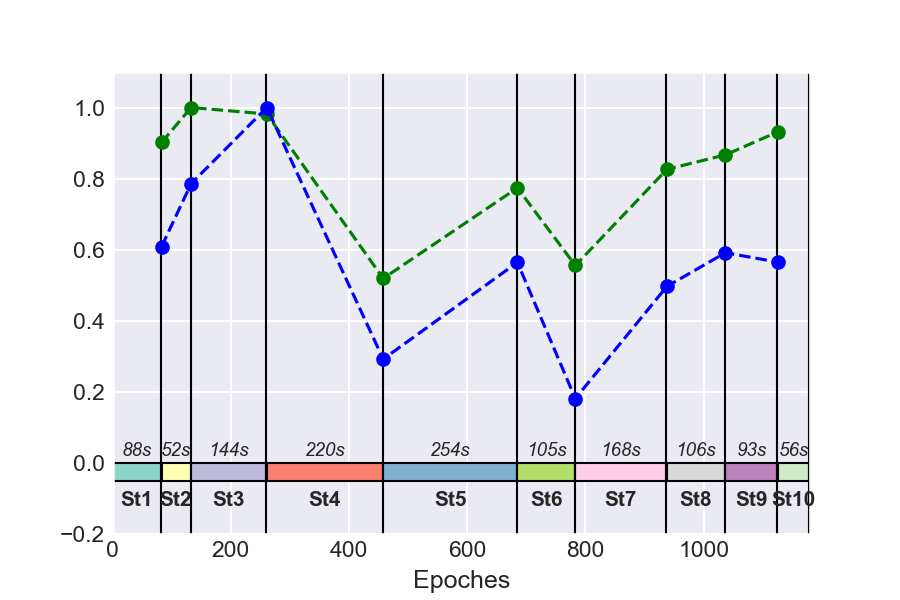

In [34]:
# Plotting stages, distances, silh between adjacent

df_features = df_ft_tot_pca
#st_bands, st_labels = spr.form_stage_bands(st_edges_result)
#n_stages = len(st_bands)

# Getting time length of the stages
cluster_events = epochs_filt_rr.events.copy() # for m10 and m3
#cluster_events = epochs_filt_rr[:-2].events.copy() # for m8 (artifacts at the end)
cluster_events[:,2] = st_labels
time_bands = []
for i in range(n_stages):
    cl_samples = np.where(cluster_events[:,2] == i)[0]
    time_bands.append((cluster_events[cl_samples[0]][0], cluster_events[cl_samples[-1]][0], st_bands[i][2]))
st_time_len = [round((time_bands[i][1]-time_bands[i][0])/sampling_rate) for i in range(n_stages)]

print(st_edges_result)
print(st_time_len)
display(df_adj_st_metr)

# Plotting stages
pal = plt.get_cmap('Set3')
#pal = plt.get_cmap('gist_ncar')

fig, ax = plt.subplots(figsize=(6,4))
for _st in range(n_stages):
    # Set x & y limits
    (ymin, ymax) = (-0.2, 1.1)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(0, n_samples)
    
    # Stages plot
    (x_start, x_end, st_name) = st_bands[_st]
    x = np.arange(x_start, x_end+1)
    y = np.full(len(x), 0)    
    event_label = 'N=%d' % (x_end-x_start+1)
    ax.add_patch(Rectangle((x_start, -0.05), x_end-x_start, 0.05, edgecolor = 'black', 
                           facecolor = pal(_st/(n_stages)), fill=True, lw=1)) # for 8 stages
                           #facecolor = pal(_st/(n_stages-1)), fill=True, lw=1)) # for 9 stages
                           #facecolor = pal(_st/(n_stages+1)), fill=True, lw=1)) # for 10 stages
    
    # Vertical lines (stage boundaries)
    ax.vlines(x_end, ymin=ymin, ymax=ymax, color='black', linewidth=1) # black lines
    #ax.vlines(x_end, ymin=ymin, ymax=ymax, color=pal(_st/(n_stages-1))) # colored lines
    
    # Background colors
    #ax.axvspan(x_start, x_end, alpha=0.3, color=pal(_st/(n_stages-1)))
   
    # Add text (st_name & st_length in sec)
    plt.text((x_start+x_end)/2, -0.12, st_name, fontsize=10, fontweight='bold', horizontalalignment='center')
    plt.text((x_start+x_end)/2, 0.02, str(st_time_len[_st])+'s', fontsize=9, fontstyle='italic', horizontalalignment='center')
    
# Adjacent stage distances (Centroid) & Silh coef 
x_dist = st_edges_result[1:-1]
y_centr = [_dist/st_dist_centr_max for _dist in st_dist_centr]
y_silh = [_dist/st_metr_silh_max for _dist in st_metr_silh]
#y_calh = [_dist/st_metr_calh_max for _dist in st_metr_calh]
#y_davb = [_dist/st_metr_davb_max for _dist in st_metr_davb]
    
ax.plot(x_dist, y_centr, linestyle='--', marker='o', color='green', label='Centroid distance')
ax.plot(x_dist, y_silh, linestyle='--', marker='o', color='blue', label='Silhouette score')
#ax.plot(x_dist, y_calh, linestyle='--', marker='o', color='orange', label='Cal-Har metric')
#ax.plot(x_dist, y_davb, linestyle='--', marker='o', color='red', label='Davies-Bouldin score')

ax.set(xlabel='Epoches')
ax.tick_params(axis='both', labelsize=11, direction='in')
#plt.savefig(subj_dir_name + ' meditation stages.png')

#plt.tight_layout(rect=[-0.01,0.05,1,1])
#handles, labels = ax.get_legend_handles_labels()
#leg = fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=11, handlelength=4)# , mode='expand')


## Shuffled initial stages 

In [46]:
# PCA decomposition

# Number of PCA compnents
#N_COMP = 0.7
N_COMP = 15

df_ft_tot_orig_stg = pd.concat([df_ft_psd_loc_db_sc_stg, df_ft_psd_ind_loc_sc_stg, df_ft_coh_ind_loc_sc_stg, 
                            df_ft_plv_ind_loc_sc_stg], axis=1)
n_features = len(df_ft_tot_orig_stg.columns)

pca = decomposition.PCA(n_components=N_COMP)

ft_tot_pca_stg = pca.fit_transform(df_ft_tot_orig_stg)
print(ft_tot_pca_stg.shape)
print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
print([round(x,3) for x in pca.explained_variance_ratio_])


n_pca_comps = len(ft_tot_pca_stg[0,:])
pca_comp_names = ['PCA_'+str(i) for i in range(n_pca_comps)]
#print(n_pca_comps)
print(n_features)
print(n_samples)

df_ft_tot_pca_stg = pd.DataFrame()
df_ft_tot_pca_stg = pd.DataFrame(ft_tot_pca_stg, columns=pca_comp_names)
display(df_ft_tot_pca_stg)

(1180, 15)
Explained variance 0.72
[0.323, 0.095, 0.07, 0.043, 0.032, 0.025, 0.023, 0.02, 0.018, 0.016, 0.014, 0.012, 0.011, 0.01, 0.009]
765
1180


,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14
0,-22.37,-0.30,0.68,-0.80,-4.67,2.82,-2.10,2.22,-1.08,-3.08,1.97,-2.52,7.09,0.95,1.90
1,-21.00,-0.82,1.80,-2.63,-2.70,0.14,-5.14,2.19,-0.61,-2.36,0.56,-4.48,4.59,0.06,-0.08
2,-9.94,5.45,3.70,-5.79,7.65,-4.04,0.19,-1.57,-0.03,-0.52,0.35,-5.80,4.81,-0.84,-1.82
3,-3.72,-2.82,4.82,-3.67,6.77,2.16,-0.57,-0.48,-2.39,0.28,1.98,-1.37,6.44,0.13,2.67
4,9.42,5.14,4.32,-7.88,-1.35,-3.61,1.78,-3.56,-1.89,3.54,-0.76,3.26,2.88,2.49,2.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,7.82,0.81,8.57,-0.32,-12.02,7.97,1.96,2.19,-6.66,3.59,3.57,-3.67,1.91,3.22,-2.21
1176,16.51,-1.64,7.08,-9.35,-3.58,10.87,7.86,-0.53,-4.47,5.82,2.08,-0.99,3.16,2.03,1.83
1177,11.34,6.57,4.49,-7.60,-12.02,1.48,4.61,-0.28,-0.45,1.81,2.82,-3.56,2.11,-5.41,-1.33
1178,8.42,0.65,5.09,-9.37,-5.09,6.18,6.43,-1.88,-2.59,-0.37,3.60,-3.40,8.72,-4.92,1.18


In [47]:
# Calculate stage distances & clustering quality metrics

df_features = df_ft_tot_pca_stg

# Main data
df_adj_st_metr = calc_stage_metr_noground(df_features, st_edges_init)
st_metr_silh = df_adj_st_metr['Silh'].to_numpy()
st_metr_calh = df_adj_st_metr['Cal-Har'].to_numpy()
st_metr_davb = df_adj_st_metr['Dav-Bold'].to_numpy()

st_dist_ward, st_dist_centr = spr.calc_stage_distances(df_features, st_edges_init)
df_adj_st_metr['Centr'] = st_dist_centr
df_adj_st_metr['Ward'] = st_dist_ward

# Max distance values for plotting
st_dist_centr_max = np.max(st_dist_centr)
st_dist_ward_max = np.max(st_dist_ward)
st_metr_silh_max = np.max(st_metr_silh)
st_metr_calh_max = np.max(st_metr_calh)
st_metr_davb_max = np.max(st_metr_davb)

print('Centr:', round(st_dist_centr_max,2), ' Silh:', round(st_metr_silh_max,2), ' Davb:', round(st_metr_davb_max,2), 
      ' Ward:', round(st_dist_ward_max,2), ' Calh:', round(st_metr_calh_max,2))
display(df_adj_st_metr)


Centr: 27.73  Silh: 0.38  Davb: 2.49  Ward: 38482.04  Calh: 122.13


,Stages,Silh,Cal-Har,Dav-Bold,Centr,Ward
0,St1_St2,0.18,92.66,1.95,20.44,"38,482.04"
1,St2_St3,0.18,50.84,2.15,18.30,"20,345.38"
2,St3_St4,0.20,42.55,1.67,23.05,"17,381.60"
3,St4_St5,0.24,42.56,1.50,23.06,"13,811.09"
4,St5_St6,0.38,122.13,1.12,27.73,"30,659.06"
5,St6_St7,0.20,82.08,1.87,17.68,"24,241.11"
6,St7_St8,0.15,36.71,2.31,17.04,"15,237.56"
7,St8_St9,0.12,28.48,2.49,15.61,"11,414.22"
8,St9_St10,0.20,59.77,1.75,21.48,"22,718.78"


[0, 155, 382, 465, 519, 569, 766, 894, 983, 1082, 1180]
[166, 256, 96, 62, 51, 214, 139, 95, 107, 101]


,Stages,Silh,Cal-Har,Dav-Bold,Centr,Ward
0,St1_St2,0.18,92.66,1.95,20.44,"38,482.04"
1,St2_St3,0.18,50.84,2.15,18.30,"20,345.38"
2,St3_St4,0.20,42.55,1.67,23.05,"17,381.60"
3,St4_St5,0.24,42.56,1.50,23.06,"13,811.09"
4,St5_St6,0.38,122.13,1.12,27.73,"30,659.06"
5,St6_St7,0.20,82.08,1.87,17.68,"24,241.11"
6,St7_St8,0.15,36.71,2.31,17.04,"15,237.56"
7,St8_St9,0.12,28.48,2.49,15.61,"11,414.22"
8,St9_St10,0.20,59.77,1.75,21.48,"22,718.78"


<IPython.core.display.Javascript object>


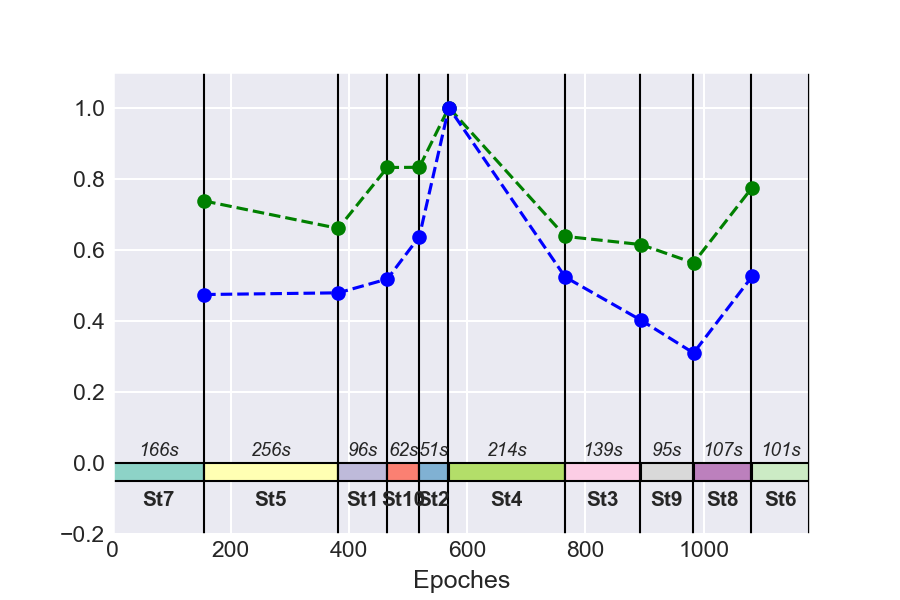

In [48]:
# Plotting stages, distances, silh between adjacent

df_features = df_ft_tot_pca_stg
st_bands_init, st_labels_init = spr.form_stage_bands(st_edges_init)
n_stages = len(st_bands_init)

# Getting time length of the stages
cluster_events = epochs_filt_rr.events.copy() # for m10 and m3
#cluster_events = epochs_filt_rr[:-2].events.copy() # for m8 (artifacts at the end)
cluster_events[:,2] = st_labels_init
time_bands = []
for i in range(n_stages):
    cl_samples = np.where(cluster_events[:,2] == i)[0]
    time_bands.append((cluster_events[cl_samples[0]][0], cluster_events[cl_samples[-1]][0], st_bands_init[i][2]))
st_time_len = [round((time_bands[i][1]-time_bands[i][0])/sampling_rate) for i in range(n_stages)]

print(st_edges_init)
print(st_time_len)
display(df_adj_st_metr)

# Plotting stages
pal = plt.get_cmap('Set3')
#pal = plt.get_cmap('gist_ncar')

fig, ax = plt.subplots(figsize=(6,4))
for _st in range(n_stages):
    # Set x & y limits
    (ymin, ymax) = (-0.2, 1.1)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(0, n_samples)
    
    # Stages plot
    (x_start, x_end, _) = st_bands_init[_st]
    st_name = st_names_init[_st]
    x = np.arange(x_start, x_end+1)
    y = np.full(len(x), 0)    
    event_label = 'N=%d' % (x_end-x_start+1)
    ax.add_patch(Rectangle((x_start, -0.05), x_end-x_start, 0.05, edgecolor = 'black', 
                           facecolor = pal(_st/(n_stages)), fill=True, lw=1)) # for 8 stages
                           #facecolor = pal(_st/(n_stages-1)), fill=True, lw=1)) # for 9 stages
                           #facecolor = pal(_st/(n_stages+1)), fill=True, lw=1)) # for 10 stages
    
    # Vertical lines (stage boundaries)
    ax.vlines(x_end, ymin=ymin, ymax=ymax, color='black', linewidth=1) # black lines
    #ax.vlines(x_end, ymin=ymin, ymax=ymax, color=pal(_st/(n_stages-1))) # colored lines
    
    # Background colors
    #ax.axvspan(x_start, x_end, alpha=0.3, color=pal(_st/(n_stages-1)))
   
    # Add text (st_name & st_length in sec)
    plt.text((x_start+x_end)/2, -0.12, st_name, fontsize=10, fontweight='bold', horizontalalignment='center')
    plt.text((x_start+x_end)/2, 0.02, str(st_time_len[_st])+'s', fontsize=9, fontstyle='italic', horizontalalignment='center')
    
# Adjacent stage distances (Centroid) & Silh coef 
x_dist = st_edges_init[1:-1]
y_centr = [_dist/st_dist_centr_max for _dist in st_dist_centr]
y_silh = [_dist/st_metr_silh_max for _dist in st_metr_silh]
#y_calh = [_dist/st_metr_calh_max for _dist in st_metr_calh]
#y_davb = [_dist/st_metr_davb_max for _dist in st_metr_davb]
    
ax.plot(x_dist, y_centr, linestyle='--', marker='o', color='green', label='Centroid distance')
ax.plot(x_dist, y_silh, linestyle='--', marker='o', color='blue', label='Silhouette score')
#ax.plot(x_dist, y_calh, linestyle='--', marker='o', color='orange', label='Cal-Har metric')
#ax.plot(x_dist, y_davb, linestyle='--', marker='o', color='red', label='Davies-Bouldin score')

ax.set(xlabel='Epoches')
ax.tick_params(axis='both', labelsize=11, direction='in')
#plt.savefig(subj_dir_name + ' meditation stages.png')

#plt.tight_layout(rect=[-0.01,0.05,1,1])
#handles, labels = ax.get_legend_handles_labels()
#leg = fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=11, handlelength=4)# , mode='expand')


# Global variables

In [147]:
gc.collect()

30

In [23]:
# Frequency bands

bands = [(0.9, 4, 'Delta (0.9-4 Hz)', 'D'), (4, 8, 'Theta (4-8 Hz)', 'T'), (8, 14, 'Alpha (8-14 Hz)', 'A'), 
         (14, 25, 'Beta (14-25 Hz)', 'B'), (25, 40, 'Gamma (25-40 Hz)', 'G')]

bands_test = [(0.9, 4, 'Delta (0.9-4 Hz)', 'D'), (4, 7, 'Theta (4-7 Hz)', 'T'), (7, 10, 'Alpha1 (7-10 Hz)','A1'), 
         (10, 13, 'Alpha2 (10-13 Hz)', 'A2'), (13, 20, 'Beta1 (13-20 Hz)', 'B1'), (20, 30, 'Beta2 (20-30 Hz)', 'B2'), 
         (30, 45, 'Gamma (30-45 Hz)', 'G')]

str_freq = [bands[i][3] for i in range(len(bands))]
#str_freq_rr = ['r'+_str for _str in str_freq]
str_freq_rr = str_freq
n_freq = len(str_freq_rr)


In [24]:
# Localization by scalp regions

regions = [(['Fp1','Fp2','Fpz'], 'Fp', 'Pre-frontal'), (['F7','F3','FT7','FC3'], 'LF', 'Left Frontal'), 
           (['Fz','FCz'], 'MF', 'Midline Frontal'), (['F4','F8','FC4','FT8'], 'RF', 'Right Frontal'),
           (['T3','TP7','T5'], 'LT', 'Left Temporal'), (['T4','TP8','T6'], 'RT', 'Right Temporal'), 
           (['C3','CP3'], 'LC', 'Left Central'), (['Cz','CPz'], 'MC', 'Midline Central'), (['C4','CP4'], 'RC', 'Right Central'),
           (['P3','P5'], 'LP', 'Left Parietal'), (['Pz'], 'MP', 'Midline Parietal'), (['P4','P6'], 'RP', 'Right Parietal'), 
           (['PO3','PO7','O1'], 'LO', 'Left Occipital'), (['POz','Oz'], 'MO', 'Midline Occipital'), 
           (['PO4','PO8','O2'], 'RO', 'Right Occipital')]
regions_plt = [(['Fp1','Fp2','Fpz'], 'Fp', 'Pre-frontal'), (['F7','F3','FT7','FC3'], 'LF', 'Left Frontal'), 
           (['Fz','FCz'], 'MF', 'Midline Frontal'), (['F4','F8','FC4','FT8'], 'RF', 'Right Frontal'),
           (['T3','TP7','T5'], 'LT', 'Left Temporal'), (['T4','TP8','T6'], 'RT', 'Right Temporal'), 
           (['C3','CP3','Cz','CPz','C4','CP4'], 'Cen', 'Central'), (['P3','P5','Pz','P4','P6'], 'Par', 'Parietal'), 
           (['PO3','PO7','O1','POz','Oz','PO4','PO8','O2'], 'Occ', 'Occipital')]

n_regions = len(regions)
n_regions_plt = len(regions_plt)

# Stage-detecting algorithm

## Clustering process

In [25]:
# PCA decomposition

# Number of PCA compnents
#N_COMP = 0.7
N_COMP = 15

df_ft_tot_orig_stg = pd.concat([df_ft_psd_loc_db_sc_stg, df_ft_psd_ind_loc_sc_stg, df_ft_coh_ind_loc_sc_stg, 
                            df_ft_plv_ind_loc_sc_stg], axis=1)
n_features = len(df_ft_tot_orig_stg.columns)

pca = decomposition.PCA(n_components=N_COMP)

ft_tot_pca_stg = pca.fit_transform(df_ft_tot_orig_stg)
print(ft_tot_pca_stg.shape)
print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
print([round(x,3) for x in pca.explained_variance_ratio_])


n_pca_comps = len(ft_tot_pca_stg[0,:])
pca_comp_names = ['PCA_'+str(i) for i in range(n_pca_comps)]
#print(n_pca_comps)
print(n_features)
print(n_samples)

df_ft_tot_pca_stg = pd.DataFrame()
df_ft_tot_pca_stg = pd.DataFrame(ft_tot_pca_stg, columns=pca_comp_names)
display(df_ft_tot_pca_stg)

(1180, 15)
Explained variance 0.72
[0.323, 0.095, 0.07, 0.043, 0.032, 0.025, 0.023, 0.02, 0.018, 0.016, 0.014, 0.012, 0.011, 0.01, 0.009]
765
1180


,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14
0,-22.37,-0.30,0.68,-0.80,-4.67,2.82,-2.10,2.22,-1.08,-3.08,1.97,-2.52,7.09,0.95,1.90
1,-21.00,-0.82,1.80,-2.63,-2.70,0.14,-5.14,2.19,-0.61,-2.36,0.55,-4.48,4.59,0.06,-0.05
2,-9.94,5.45,3.70,-5.79,7.65,-4.04,0.19,-1.57,-0.03,-0.52,0.35,-5.80,4.81,-0.83,-1.84
3,-3.72,-2.82,4.82,-3.67,6.77,2.16,-0.57,-0.48,-2.39,0.28,1.98,-1.37,6.44,0.14,2.70
4,9.42,5.14,4.32,-7.88,-1.35,-3.61,1.78,-3.56,-1.89,3.54,-0.76,3.26,2.88,2.49,2.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,7.82,0.81,8.57,-0.32,-12.02,7.97,1.96,2.19,-6.66,3.59,3.57,-3.67,1.90,3.23,-2.25
1176,16.51,-1.64,7.08,-9.35,-3.58,10.87,7.86,-0.53,-4.47,5.82,2.08,-0.99,3.15,2.04,1.83
1177,11.34,6.57,4.49,-7.60,-12.02,1.48,4.61,-0.28,-0.45,1.81,2.82,-3.56,2.11,-5.41,-1.31
1178,8.42,0.65,5.09,-9.37,-5.09,6.18,6.43,-1.88,-2.59,-0.37,3.60,-3.40,8.74,-4.94,1.28


In [26]:
# Iterative automatic process of finding best clusterisation 

# Global variables
k_neighb_min = 20
k_neighb_max = 50
n_cl_min = 2
n_cl_max = 20

len_st_thr = [0, 20, 40, 60] # stage length thresholds for staging process

st_dist_rate = 0.3

#min_stage_length = 40 # minimum acceptable stage length

# Initialization
df_features = df_ft_tot_pca_stg
print(df_features.to_numpy().shape)

df_best_metrics = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])
df_st_edges = pd.DataFrame(columns=['Len_min', 'N_clusters', 'K_neighb', 'Silh', 'St_edges'])

for n_clusters in range(n_cl_min, n_cl_max+1):
    for k_neighbours in range(k_neighb_min, k_neighb_max+1):
        # Clustering, Ward method        
        cl_name = 'ward_pca_'+str(n_clusters)+'_'+str(k_neighbours)
        cl_method, df_best_metrics = apply_cluster_method(data=df_features, cl_method=AgglomerativeClustering, 
                                                          name=cl_name, df_metrics=df_best_metrics, n_clusters=n_clusters, 
                                                          linkage='ward', connectivity=knn_con_matr)
        # Forming stages from clusters
        st_edges = spr.form_stages(cl_method.labels_)
        
        # Merging stages
        for st_len_min in len_st_thr:
            st_edges = spr.merge_stages_1st_step(df_features, st_edges, len_threshold=st_len_min) 
            st_edges = spr.merge_stages_2nd_step(df_features, st_edges, dist_threshold=st_dist_rate) 
            # Insert clusterization results into DataFrame
            silh_metric = df_best_metrics[df_best_metrics['Method']==cl_name].iloc[0]['Silh']
            new_row = {'Len_min': st_len_min, 'N_clusters': n_clusters, 'K_neighb': k_neighbours, 
                                       'Silh': silh_metric, 'St_edges': st_edges}
            df_st_edges = df_st_edges.append(new_row, ignore_index = True)
            # Print results
            st_lengths = np.array([st_edges[i+1] - st_edges[i] for i in range(len(st_edges)-1)])
            print(st_len_min, n_clusters, k_neighbours, len(st_lengths), st_edges, st_lengths)

display(df_best_metrics)
display(df_st_edges)

(1180, 15)
0 2 20 3 [   0  185  382 1180] [185 197 798]
20 2 20 3 [   0  185  382 1180] [185 197 798]
40 2 20 3 [   0  185  382 1180] [185 197 798]
60 2 20 3 [   0  185  382 1180] [185 197 798]
0 2 21 3 [   0  185  382 1180] [185 197 798]
20 2 21 3 [   0  185  382 1180] [185 197 798]
40 2 21 3 [   0  185  382 1180] [185 197 798]
60 2 21 3 [   0  185  382 1180] [185 197 798]
0 2 22 3 [   0  185  382 1180] [185 197 798]
20 2 22 3 [   0  185  382 1180] [185 197 798]
40 2 22 3 [   0  185  382 1180] [185 197 798]
60 2 22 3 [   0  185  382 1180] [185 197 798]
0 2 23 2 [   0  818 1180] [818 362]
20 2 23 2 [   0  818 1180] [818 362]
40 2 23 2 [   0  818 1180] [818 362]
60 2 23 2 [   0  818 1180] [818 362]
0 2 24 2 [   0  818 1180] [818 362]
20 2 24 2 [   0  818 1180] [818 362]
40 2 24 2 [   0  818 1180] [818 362]
60 2 24 2 [   0  818 1180] [818 362]
0 2 25 3 [   0  818 1026 1180] [818 208 154]
20 2 25 3 [   0  818 1026 1180] [818 208 154]
40 2 25 3 [   0  818 1026 1180] [818 208 154]
60 2 25 3

0 3 33 4 [   0  395  569  818 1180] [395 174 249 362]
20 3 33 4 [   0  395  569  818 1180] [395 174 249 362]
40 3 33 4 [   0  395  569  818 1180] [395 174 249 362]
60 3 33 4 [   0  395  569  818 1180] [395 174 249 362]
0 3 34 5 [   0  185  382  864 1140 1180] [185 197 482 276  40]
20 3 34 5 [   0  185  382  864 1140 1180] [185 197 482 276  40]
40 3 34 4 [   0  185  382  864 1180] [185 197 482 316]
60 3 34 4 [   0  185  382  864 1180] [185 197 482 316]
0 3 35 4 [   0  395  569  836 1180] [395 174 267 344]
20 3 35 4 [   0  395  569  836 1180] [395 174 267 344]
40 3 35 4 [   0  395  569  836 1180] [395 174 267 344]
60 3 35 4 [   0  395  569  836 1180] [395 174 267 344]
0 3 36 4 [   0  395  569  836 1180] [395 174 267 344]
20 3 36 4 [   0  395  569  836 1180] [395 174 267 344]
40 3 36 4 [   0  395  569  836 1180] [395 174 267 344]
60 3 36 4 [   0  395  569  836 1180] [395 174 267 344]
0 3 37 4 [   0  395  569  836 1180] [395 174 267 344]
20 3 37 4 [   0  395  569  836 1180] [395 174 267 34

0 4 37 5 [   0  151  395  569  836 1180] [151 244 174 267 344]
20 4 37 5 [   0  151  395  569  836 1180] [151 244 174 267 344]
40 4 37 5 [   0  151  395  569  836 1180] [151 244 174 267 344]
60 4 37 5 [   0  151  395  569  836 1180] [151 244 174 267 344]
0 4 38 5 [   0  151  395  569  836 1180] [151 244 174 267 344]
20 4 38 5 [   0  151  395  569  836 1180] [151 244 174 267 344]
40 4 38 5 [   0  151  395  569  836 1180] [151 244 174 267 344]
60 4 38 5 [   0  151  395  569  836 1180] [151 244 174 267 344]
0 4 39 5 [   0  151  395  569  836 1180] [151 244 174 267 344]
20 4 39 5 [   0  151  395  569  836 1180] [151 244 174 267 344]
40 4 39 5 [   0  151  395  569  836 1180] [151 244 174 267 344]
60 4 39 5 [   0  151  395  569  836 1180] [151 244 174 267 344]
0 4 40 5 [   0  151  395  569  836 1180] [151 244 174 267 344]
20 4 40 5 [   0  151  395  569  836 1180] [151 244 174 267 344]
40 4 40 5 [   0  151  395  569  836 1180] [151 244 174 267 344]
60 4 40 5 [   0  151  395  569  836 1180] [1

0 5 36 7 [   0  151  395  569  836 1026 1088 1180] [151 244 174 267 190  62  92]
20 5 36 7 [   0  151  395  569  836 1026 1088 1180] [151 244 174 267 190  62  92]
40 5 36 7 [   0  151  395  569  836 1026 1088 1180] [151 244 174 267 190  62  92]
60 5 36 7 [   0  151  395  569  836 1026 1088 1180] [151 244 174 267 190  62  92]
0 5 37 7 [   0  151  395  569  836 1026 1088 1180] [151 244 174 267 190  62  92]
20 5 37 7 [   0  151  395  569  836 1026 1088 1180] [151 244 174 267 190  62  92]
40 5 37 7 [   0  151  395  569  836 1026 1088 1180] [151 244 174 267 190  62  92]
60 5 37 7 [   0  151  395  569  836 1026 1088 1180] [151 244 174 267 190  62  92]
0 5 38 6 [   0  151  395  569  766  836 1180] [151 244 174 197  70 344]
20 5 38 6 [   0  151  395  569  766  836 1180] [151 244 174 197  70 344]
40 5 38 6 [   0  151  395  569  766  836 1180] [151 244 174 197  70 344]
60 5 38 6 [   0  151  395  569  766  836 1180] [151 244 174 197  70 344]
0 5 39 6 [   0  151  395  569  766  836 1180] [151 244 

0 6 32 6 [   0  153  395  569  766  818 1180] [153 242 174 197  52 362]
20 6 32 6 [   0  153  395  569  766  818 1180] [153 242 174 197  52 362]
40 6 32 6 [   0  153  395  569  766  818 1180] [153 242 174 197  52 362]
60 6 32 5 [   0  153  395  569  766 1180] [153 242 174 197 414]
0 6 33 6 [   0  151  395  569  766  818 1180] [151 244 174 197  52 362]
20 6 33 6 [   0  151  395  569  766  818 1180] [151 244 174 197  52 362]
40 6 33 6 [   0  151  395  569  766  818 1180] [151 244 174 197  52 362]
60 6 33 5 [   0  151  395  569  766 1180] [151 244 174 197 414]
0 6 34 6 [   0  185  382  569  766  864 1180] [185 197 187 197  98 316]
20 6 34 6 [   0  185  382  569  766  864 1180] [185 197 187 197  98 316]
40 6 34 6 [   0  185  382  569  766  864 1180] [185 197 187 197  98 316]
60 6 34 6 [   0  185  382  569  766  864 1180] [185 197 187 197  98 316]
0 6 35 7 [   0  151  382  569  836 1026 1088 1180] [151 231 187 267 190  62  92]
20 6 35 7 [   0  151  382  569  836 1026 1088 1180] [151 231 187

0 7 27 6 [   0  153  382  569  766  818 1180] [153 229 187 197  52 362]
20 7 27 6 [   0  153  382  569  766  818 1180] [153 229 187 197  52 362]
40 7 27 6 [   0  153  382  569  766  818 1180] [153 229 187 197  52 362]
60 7 27 5 [   0  153  382  569  766 1180] [153 229 187 197 414]
0 7 28 6 [   0  153  382  569  766  818 1180] [153 229 187 197  52 362]
20 7 28 6 [   0  153  382  569  766  818 1180] [153 229 187 197  52 362]
40 7 28 6 [   0  153  382  569  766  818 1180] [153 229 187 197  52 362]
60 7 28 5 [   0  153  382  569  766 1180] [153 229 187 197 414]
0 7 29 6 [   0  153  395  569  766  818 1180] [153 242 174 197  52 362]
20 7 29 6 [   0  153  395  569  766  818 1180] [153 242 174 197  52 362]
40 7 29 6 [   0  153  395  569  766  818 1180] [153 242 174 197  52 362]
60 7 29 5 [   0  153  395  569  766 1180] [153 242 174 197 414]
0 7 30 6 [   0  153  395  569  766  818 1180] [153 242 174 197  52 362]
20 7 30 6 [   0  153  395  569  766  818 1180] [153 242 174 197  52 362]
40 7 30 6

0 8 23 9 [   0  155  382  465  569  766  818 1048 1088 1180] [155 227  83 104 197  52 230  40  92]
20 8 23 9 [   0  155  382  465  569  766  818 1048 1088 1180] [155 227  83 104 197  52 230  40  92]
40 8 23 8 [   0  155  382  465  569  766  818 1088 1180] [155 227  83 104 197  52 270  92]
60 8 23 6 [   0  155  382  465  569  766 1180] [155 227  83 104 197 414]
0 8 24 8 [   0  153  395  465  491  569  766  818 1180] [153 242  70  26  78 197  52 362]
20 8 24 8 [   0  153  395  465  491  569  766  818 1180] [153 242  70  26  78 197  52 362]
40 8 24 7 [   0  153  395  465  569  766  818 1180] [153 242  70 104 197  52 362]
60 8 24 5 [   0  153  395  569  766 1180] [153 242 174 197 414]
0 8 25 8 [   0  155  382  569  766  818 1026 1088 1180] [155 227 187 197  52 208  62  92]
20 8 25 8 [   0  155  382  569  766  818 1026 1088 1180] [155 227 187 197  52 208  62  92]
40 8 25 8 [   0  155  382  569  766  818 1026 1088 1180] [155 227 187 197  52 208  62  92]
60 8 25 7 [   0  155  382  569  766 10

0 8 50 6 [   0  155  382  569  766  836 1180] [155 227 187 197  70 344]
20 8 50 6 [   0  155  382  569  766  836 1180] [155 227 187 197  70 344]
40 8 50 6 [   0  155  382  569  766  836 1180] [155 227 187 197  70 344]
60 8 50 6 [   0  155  382  569  766  836 1180] [155 227 187 197  70 344]
0 9 20 9 [   0  153  382  465  569  766  818 1048 1088 1180] [153 229  83 104 197  52 230  40  92]
20 9 20 9 [   0  153  382  465  569  766  818 1048 1088 1180] [153 229  83 104 197  52 230  40  92]
40 9 20 8 [   0  153  382  465  569  766  818 1088 1180] [153 229  83 104 197  52 270  92]
60 9 20 6 [   0  153  382  465  569  766 1180] [153 229  83 104 197 414]
0 9 21 10 [   0  153  382  465  491  569  766  818 1048 1088 1180] [153 229  83  26  78 197  52 230  40  92]
20 9 21 10 [   0  153  382  465  491  569  766  818 1048 1088 1180] [153 229  83  26  78 197  52 230  40  92]
40 9 21 8 [   0  153  382  465  569  766  818 1088 1180] [153 229  83 104 197  52 270  92]
60 9 21 6 [   0  153  382  465  569 

0 9 45 7 [   0  155  382  569  766  894 1082 1180] [155 227 187 197 128 188  98]
20 9 45 7 [   0  155  382  569  766  894 1082 1180] [155 227 187 197 128 188  98]
40 9 45 7 [   0  155  382  569  766  894 1082 1180] [155 227 187 197 128 188  98]
60 9 45 7 [   0  155  382  569  766  894 1082 1180] [155 227 187 197 128 188  98]
0 9 46 6 [   0  155  382  569  766  836 1180] [155 227 187 197  70 344]
20 9 46 6 [   0  155  382  569  766  836 1180] [155 227 187 197  70 344]
40 9 46 6 [   0  155  382  569  766  836 1180] [155 227 187 197  70 344]
60 9 46 6 [   0  155  382  569  766  836 1180] [155 227 187 197  70 344]
0 9 47 6 [   0  155  382  569  766  836 1180] [155 227 187 197  70 344]
20 9 47 6 [   0  155  382  569  766  836 1180] [155 227 187 197  70 344]
40 9 47 6 [   0  155  382  569  766  836 1180] [155 227 187 197  70 344]
60 9 47 6 [   0  155  382  569  766  836 1180] [155 227 187 197  70 344]
0 9 48 6 [   0  155  382  569  766  836 1180] [155 227 187 197  70 344]
20 9 48 6 [   0  15

0 10 40 6 [   0  155  382  569  766  836 1180] [155 227 187 197  70 344]
20 10 40 6 [   0  155  382  569  766  836 1180] [155 227 187 197  70 344]
40 10 40 6 [   0  155  382  569  766  836 1180] [155 227 187 197  70 344]
60 10 40 6 [   0  155  382  569  766  836 1180] [155 227 187 197  70 344]
0 10 41 8 [   0  155  382  569  766  836 1026 1088 1180] [155 227 187 197  70 190  62  92]
20 10 41 8 [   0  155  382  569  766  836 1026 1088 1180] [155 227 187 197  70 190  62  92]
40 10 41 8 [   0  155  382  569  766  836 1026 1088 1180] [155 227 187 197  70 190  62  92]
60 10 41 8 [   0  155  382  569  766  836 1026 1088 1180] [155 227 187 197  70 190  62  92]
0 10 42 6 [   0  155  382  569  766  836 1180] [155 227 187 197  70 344]
20 10 42 6 [   0  155  382  569  766  836 1180] [155 227 187 197  70 344]
40 10 42 6 [   0  155  382  569  766  836 1180] [155 227 187 197  70 344]
60 10 42 6 [   0  155  382  569  766  836 1180] [155 227 187 197  70 344]
0 10 43 6 [   0  155  382  569  766  836 11

0 11 34 12 [   0  155  185  382  395  569  622  766  804  864  966 1140 1180] [155  30 197  13 174  53 144  38  60 102 174  40]
20 11 34 6 [   0  155  382  569  766  864 1180] [155 227 187 197  98 316]
40 11 34 6 [   0  155  382  569  766  864 1180] [155 227 187 197  98 316]
60 11 34 6 [   0  155  382  569  766  864 1180] [155 227 187 197  98 316]
0 11 35 8 [   0  155  382  569  766  836 1026 1088 1180] [155 227 187 197  70 190  62  92]
20 11 35 8 [   0  155  382  569  766  836 1026 1088 1180] [155 227 187 197  70 190  62  92]
40 11 35 8 [   0  155  382  569  766  836 1026 1088 1180] [155 227 187 197  70 190  62  92]
60 11 35 8 [   0  155  382  569  766  836 1026 1088 1180] [155 227 187 197  70 190  62  92]
0 11 36 8 [   0  155  382  569  766  836 1026 1088 1180] [155 227 187 197  70 190  62  92]
20 11 36 8 [   0  155  382  569  766  836 1026 1088 1180] [155 227 187 197  70 190  62  92]
40 11 36 8 [   0  155  382  569  766  836 1026 1088 1180] [155 227 187 197  70 190  62  92]
60 11 36

0 12 28 7 [   0  155  382  569  766  894 1088 1180] [155 227 187 197 128 194  92]
20 12 28 7 [   0  155  382  569  766  894 1088 1180] [155 227 187 197 128 194  92]
40 12 28 7 [   0  155  382  569  766  894 1088 1180] [155 227 187 197 128 194  92]
60 12 28 7 [   0  155  382  569  766  894 1088 1180] [155 227 187 197 128 194  92]
0 12 29 7 [   0  155  382  569  766  894 1088 1180] [155 227 187 197 128 194  92]
20 12 29 7 [   0  155  382  569  766  894 1088 1180] [155 227 187 197 128 194  92]
40 12 29 7 [   0  155  382  569  766  894 1088 1180] [155 227 187 197 128 194  92]
60 12 29 7 [   0  155  382  569  766  894 1088 1180] [155 227 187 197 128 194  92]
0 12 30 7 [   0  155  382  569  766  894 1088 1180] [155 227 187 197 128 194  92]
20 12 30 7 [   0  155  382  569  766  894 1088 1180] [155 227 187 197 128 194  92]
40 12 30 7 [   0  155  382  569  766  894 1088 1180] [155 227 187 197 128 194  92]
60 12 30 7 [   0  155  382  569  766  894 1088 1180] [155 227 187 197 128 194  92]
0 12 31

0 13 22 11 [   0  155  382  465  491  569  766  808  905  957 1088 1180] [155 227  83  26  78 197  42  97  52 131  92]
20 13 22 11 [   0  155  382  465  491  569  766  808  905  957 1088 1180] [155 227  83  26  78 197  42  97  52 131  92]
40 13 22 10 [   0  155  382  465  569  766  808  905  957 1088 1180] [155 227  83 104 197  42  97  52 131  92]
60 13 22 8 [   0  155  382  465  569  766  905 1088 1180] [155 227  83 104 197 139 183  92]
0 13 23 10 [   0  155  382  465  491  569  766  818 1048 1088 1180] [155 227  83  26  78 197  52 230  40  92]
20 13 23 10 [   0  155  382  465  491  569  766  818 1048 1088 1180] [155 227  83  26  78 197  52 230  40  92]
40 13 23 8 [   0  155  382  465  569  766  818 1088 1180] [155 227  83 104 197  52 270  92]
60 13 23 6 [   0  155  382  465  569  766 1180] [155 227  83 104 197 414]
0 13 24 10 [   0  155  382  465  491  569  766  808  894 1088 1180] [155 227  83  26  78 197  42  86 194  92]
20 13 24 10 [   0  155  382  465  491  569  766  808  894 108

0 13 44 8 [   0  155  382  465  569  766  887 1082 1180] [155 227  83 104 197 121 195  98]
20 13 44 8 [   0  155  382  465  569  766  887 1082 1180] [155 227  83 104 197 121 195  98]
40 13 44 8 [   0  155  382  465  569  766  887 1082 1180] [155 227  83 104 197 121 195  98]
60 13 44 8 [   0  155  382  465  569  766  887 1082 1180] [155 227  83 104 197 121 195  98]
0 13 45 8 [   0  155  382  569  766  894  965 1088 1180] [155 227 187 197 128  71 123  92]
20 13 45 8 [   0  155  382  569  766  894  965 1088 1180] [155 227 187 197 128  71 123  92]
40 13 45 8 [   0  155  382  569  766  894  965 1088 1180] [155 227 187 197 128  71 123  92]
60 13 45 8 [   0  155  382  569  766  894  965 1088 1180] [155 227 187 197 128  71 123  92]
0 13 46 8 [   0  155  382  465  569  766  894 1140 1180] [155 227  83 104 197 128 246  40]
20 13 46 8 [   0  155  382  465  569  766  894 1140 1180] [155 227  83 104 197 128 246  40]
40 13 46 7 [   0  155  382  465  569  766  894 1180] [155 227  83 104 197 128 286]


0 14 35 10 [   0  155  382  465  569  766  820  907 1026 1088 1180] [155 227  83 104 197  54  87 119  62  92]
20 14 35 10 [   0  155  382  465  569  766  820  907 1026 1088 1180] [155 227  83 104 197  54  87 119  62  92]
40 14 35 10 [   0  155  382  465  569  766  820  907 1026 1088 1180] [155 227  83 104 197  54  87 119  62  92]
60 14 35 9 [   0  155  382  465  569  766  907 1026 1088 1180] [155 227  83 104 197 141 119  62  92]
0 14 36 10 [   0  155  382  465  569  766  820  907 1026 1088 1180] [155 227  83 104 197  54  87 119  62  92]
20 14 36 10 [   0  155  382  465  569  766  820  907 1026 1088 1180] [155 227  83 104 197  54  87 119  62  92]
40 14 36 10 [   0  155  382  465  569  766  820  907 1026 1088 1180] [155 227  83 104 197  54  87 119  62  92]
60 14 36 9 [   0  155  382  465  569  766  907 1026 1088 1180] [155 227  83 104 197 141 119  62  92]
0 14 37 9 [   0  155  382  465  569  766  907 1026 1088 1180] [155 227  83 104 197 141 119  62  92]
20 14 37 9 [   0  155  382  465  5

0 15 25 10 [   0  155  382  465  515  569  766  818  984 1088 1180] [155 227  83  50  54 197  52 166 104  92]
20 15 25 10 [   0  155  382  465  515  569  766  818  984 1088 1180] [155 227  83  50  54 197  52 166 104  92]
40 15 25 10 [   0  155  382  465  515  569  766  818  984 1088 1180] [155 227  83  50  54 197  52 166 104  92]
60 15 25 8 [   0  155  382  465  569  766  984 1088 1180] [155 227  83 104 197 218 104  92]
0 15 26 12 [   0  155  319  382  465  491  569  766  808  894  966 1088 1180] [155 164  63  83  26  78 197  42  86  72 122  92]
20 15 26 12 [   0  155  319  382  465  491  569  766  808  894  966 1088 1180] [155 164  63  83  26  78 197  42  86  72 122  92]
40 15 26 11 [   0  155  319  382  465  569  766  808  894  966 1088 1180] [155 164  63  83 104 197  42  86  72 122  92]
60 15 26 10 [   0  155  319  382  465  569  766  894  966 1088 1180] [155 164  63  83 104 197 128  72 122  92]
0 15 27 15 [   0  155  185  282  382  395  530  569  622  766  808  894  966 1088
 1128 

0 15 45 9 [   0  155  382  465  569  766  894  965 1088 1180] [155 227  83 104 197 128  71 123  92]
20 15 45 9 [   0  155  382  465  569  766  894  965 1088 1180] [155 227  83 104 197 128  71 123  92]
40 15 45 9 [   0  155  382  465  569  766  894  965 1088 1180] [155 227  83 104 197 128  71 123  92]
60 15 45 9 [   0  155  382  465  569  766  894  965 1088 1180] [155 227  83 104 197 128  71 123  92]
0 15 46 9 [   0  155  382  465  569  766  894  965 1088 1180] [155 227  83 104 197 128  71 123  92]
20 15 46 9 [   0  155  382  465  569  766  894  965 1088 1180] [155 227  83 104 197 128  71 123  92]
40 15 46 9 [   0  155  382  465  569  766  894  965 1088 1180] [155 227  83 104 197 128  71 123  92]
60 15 46 9 [   0  155  382  465  569  766  894  965 1088 1180] [155 227  83 104 197 128  71 123  92]
0 15 47 8 [   0  155  382  465  569  766  894 1140 1180] [155 227  83 104 197 128 246  40]
20 15 47 8 [   0  155  382  465  569  766  894 1140 1180] [155 227  83 104 197 128 246  40]
40 15 47 7 

0 16 34 9 [   0  155  382  465  569  766  894  966 1088 1180] [155 227  83 104 197 128  72 122  92]
20 16 34 9 [   0  155  382  465  569  766  894  966 1088 1180] [155 227  83 104 197 128  72 122  92]
40 16 34 9 [   0  155  382  465  569  766  894  966 1088 1180] [155 227  83 104 197 128  72 122  92]
60 16 34 9 [   0  155  382  465  569  766  894  966 1088 1180] [155 227  83 104 197 128  72 122  92]
0 16 35 10 [   0  155  382  465  569  766  820  894  968 1088 1180] [155 227  83 104 197  54  74  74 120  92]
20 16 35 10 [   0  155  382  465  569  766  820  894  968 1088 1180] [155 227  83 104 197  54  74  74 120  92]
40 16 35 10 [   0  155  382  465  569  766  820  894  968 1088 1180] [155 227  83 104 197  54  74  74 120  92]
60 16 35 9 [   0  155  382  465  569  766  894  968 1088 1180] [155 227  83 104 197 128  74 120  92]
0 16 36 10 [   0  155  382  465  569  766  820  894  968 1088 1180] [155 227  83 104 197  54  74  74 120  92]
20 16 36 10 [   0  155  382  465  569  766  820  894  

0 17 24 11 [   0  155  382  465  515  569  766  808  894  966 1088 1180] [155 227  83  50  54 197  42  86  72 122  92]
20 17 24 11 [   0  155  382  465  515  569  766  808  894  966 1088 1180] [155 227  83  50  54 197  42  86  72 122  92]
40 17 24 11 [   0  155  382  465  515  569  766  808  894  966 1088 1180] [155 227  83  50  54 197  42  86  72 122  92]
60 17 24 9 [   0  155  382  465  569  766  894  966 1088 1180] [155 227  83 104 197 128  72 122  92]
0 17 25 11 [   0  155  382  465  515  569  766  808  905  966 1088 1180] [155 227  83  50  54 197  42  97  61 122  92]
20 17 25 11 [   0  155  382  465  515  569  766  808  905  966 1088 1180] [155 227  83  50  54 197  42  97  61 122  92]
40 17 25 11 [   0  155  382  465  515  569  766  808  905  966 1088 1180] [155 227  83  50  54 197  42  97  61 122  92]
60 17 25 9 [   0  155  382  465  569  766  905  966 1088 1180] [155 227  83 104 197 139  61 122  92]
0 17 26 12 [   0  155  319  382  465  530  569  766  808  894  966 1088 1180] [1

0 17 42 11 [   0  155  382  465  519  569  766  804  905  977 1088 1180] [155 227  83  54  50 197  38 101  72 111  92]
20 17 42 11 [   0  155  382  465  519  569  766  804  905  977 1088 1180] [155 227  83  54  50 197  38 101  72 111  92]
40 17 42 10 [   0  155  382  465  519  569  766  905  977 1088 1180] [155 227  83  54  50 197 139  72 111  92]
60 17 42 9 [   0  155  382  465  569  766  905  977 1088 1180] [155 227  83 104 197 139  72 111  92]
0 17 43 11 [   0  155  382  465  519  569  766  804  894  977 1088 1180] [155 227  83  54  50 197  38  90  83 111  92]
20 17 43 11 [   0  155  382  465  519  569  766  804  894  977 1088 1180] [155 227  83  54  50 197  38  90  83 111  92]
40 17 43 10 [   0  155  382  465  519  569  766  894  977 1088 1180] [155 227  83  54  50 197 128  83 111  92]
60 17 43 9 [   0  155  382  465  569  766  894  977 1088 1180] [155 227  83 104 197 128  83 111  92]
0 17 44 11 [   0  155  382  465  515  569  766  804  894  965 1088 1180] [155 227  83  50  54 197 

0 18 30 12 [   0  155  319  382  465  519  569  766  808  894  966 1088 1180] [155 164  63  83  54  50 197  42  86  72 122  92]
20 18 30 12 [   0  155  319  382  465  519  569  766  808  894  966 1088 1180] [155 164  63  83  54  50 197  42  86  72 122  92]
40 18 30 12 [   0  155  319  382  465  519  569  766  808  894  966 1088 1180] [155 164  63  83  54  50 197  42  86  72 122  92]
60 18 30 10 [   0  155  319  382  465  569  766  894  966 1088 1180] [155 164  63  83 104 197 128  72 122  92]
0 18 31 17 [   0  155  185  282  382  465  473  489  519  569  715  766  808  894
  977 1088 1130 1180] [155  30  97 100  83   8  16  30  50 146  51  42  86  83 111  42  50]
20 18 31 11 [   0  155  382  465  519  569  766  808  894  977 1088 1180] [155 227  83  54  50 197  42  86  83 111  92]
40 18 31 11 [   0  155  382  465  519  569  766  808  894  977 1088 1180] [155 227  83  54  50 197  42  86  83 111  92]
60 18 31 9 [   0  155  382  465  569  766  894  977 1088 1180] [155 227  83 104 197 128  

0 18 48 11 [   0  155  382  465  519  569  766  804  894  965 1080 1180] [155 227  83  54  50 197  38  90  71 115 100]
20 18 48 11 [   0  155  382  465  519  569  766  804  894  965 1080 1180] [155 227  83  54  50 197  38  90  71 115 100]
40 18 48 10 [   0  155  382  465  519  569  766  894  965 1080 1180] [155 227  83  54  50 197 128  71 115 100]
60 18 48 9 [   0  155  382  465  569  766  894  965 1080 1180] [155 227  83 104 197 128  71 115 100]
0 18 49 9 [   0  155  382  465  569  766  888  965 1080 1180] [155 227  83 104 197 122  77 115 100]
20 18 49 9 [   0  155  382  465  569  766  888  965 1080 1180] [155 227  83 104 197 122  77 115 100]
40 18 49 9 [   0  155  382  465  569  766  888  965 1080 1180] [155 227  83 104 197 122  77 115 100]
60 18 49 9 [   0  155  382  465  569  766  888  965 1080 1180] [155 227  83 104 197 122  77 115 100]
0 18 50 11 [   0  155  382  465  519  569  766  804  888  977 1080 1180] [155 227  83  54  50 197  38  84  89 103 100]
20 18 50 11 [   0  155  382

0 19 34 11 [   0  155  382  465  519  569  766  823  894  966 1088 1180] [155 227  83  54  50 197  57  71  72 122  92]
20 19 34 11 [   0  155  382  465  519  569  766  823  894  966 1088 1180] [155 227  83  54  50 197  57  71  72 122  92]
40 19 34 11 [   0  155  382  465  519  569  766  823  894  966 1088 1180] [155 227  83  54  50 197  57  71  72 122  92]
60 19 34 9 [   0  155  382  465  569  766  894  966 1088 1180] [155 227  83 104 197 128  72 122  92]
0 19 35 11 [   0  155  382  465  519  569  766  820  894  968 1088 1180] [155 227  83  54  50 197  54  74  74 120  92]
20 19 35 11 [   0  155  382  465  519  569  766  820  894  968 1088 1180] [155 227  83  54  50 197  54  74  74 120  92]
40 19 35 11 [   0  155  382  465  519  569  766  820  894  968 1088 1180] [155 227  83  54  50 197  54  74  74 120  92]
60 19 35 9 [   0  155  382  465  569  766  894  968 1088 1180] [155 227  83 104 197 128  74 120  92]
0 19 36 11 [   0  155  382  465  519  569  766  820  894  968 1088 1180] [155 22

0 20 22 11 [   0  155  382  465  491  569  766  808  894  957 1088 1180] [155 227  83  26  78 197  42  86  63 131  92]
20 20 22 11 [   0  155  382  465  491  569  766  808  894  957 1088 1180] [155 227  83  26  78 197  42  86  63 131  92]
40 20 22 10 [   0  155  382  465  569  766  808  894  957 1088 1180] [155 227  83 104 197  42  86  63 131  92]
60 20 22 9 [   0  155  382  465  569  766  894  957 1088 1180] [155 227  83 104 197 128  63 131  92]
0 20 23 11 [   0  155  382  465  515  569  766  808  905  966 1088 1180] [155 227  83  50  54 197  42  97  61 122  92]
20 20 23 11 [   0  155  382  465  515  569  766  808  905  966 1088 1180] [155 227  83  50  54 197  42  97  61 122  92]
40 20 23 11 [   0  155  382  465  515  569  766  808  905  966 1088 1180] [155 227  83  50  54 197  42  97  61 122  92]
60 20 23 9 [   0  155  382  465  569  766  905  966 1088 1180] [155 227  83 104 197 139  61 122  92]
0 20 24 11 [   0  155  382  465  515  569  766  808  894  966 1088 1180] [155 227  83  50

0 20 39 11 [   0  155  382  465  519  569  766  804  894  977 1088 1180] [155 227  83  54  50 197  38  90  83 111  92]
20 20 39 11 [   0  155  382  465  519  569  766  804  894  977 1088 1180] [155 227  83  54  50 197  38  90  83 111  92]
40 20 39 10 [   0  155  382  465  519  569  766  894  977 1088 1180] [155 227  83  54  50 197 128  83 111  92]
60 20 39 9 [   0  155  382  465  569  766  894  977 1088 1180] [155 227  83 104 197 128  83 111  92]
0 20 40 11 [   0  155  382  465  519  569  766  822  887  977 1088 1180] [155 227  83  54  50 197  56  65  90 111  92]
20 20 40 11 [   0  155  382  465  519  569  766  822  887  977 1088 1180] [155 227  83  54  50 197  56  65  90 111  92]
40 20 40 11 [   0  155  382  465  519  569  766  822  887  977 1088 1180] [155 227  83  54  50 197  56  65  90 111  92]
60 20 40 9 [   0  155  382  465  569  766  887  977 1088 1180] [155 227  83 104 197 121  90 111  92]
0 20 41 11 [   0  155  382  465  519  569  766  822  905  977 1088 1180] [155 227  83  54

,Method,Silh,Cal-Har,Dav-Bold
0,ward_pca_2_20,0.06,91.04,1.77
1,ward_pca_2_21,0.07,90.98,1.72
2,ward_pca_2_22,0.06,90.06,1.81
3,ward_pca_2_23,0.09,85.65,2.87
4,ward_pca_2_24,0.15,147.61,1.68
...,...,...,...,...
584,ward_pca_20_46,0.02,75.76,3.57
585,ward_pca_20_47,0.02,76.77,3.04
586,ward_pca_20_48,0.02,76.64,2.87
587,ward_pca_20_49,0.01,75.70,2.89


,Len_min,N_clusters,K_neighb,Silh,St_edges
0,0,2,20,0.06,"[0, 185, 382, 1180]"
1,20,2,20,0.06,"[0, 185, 382, 1180]"
2,40,2,20,0.06,"[0, 185, 382, 1180]"
3,60,2,20,0.06,"[0, 185, 382, 1180]"
4,0,2,21,0.07,"[0, 185, 382, 1180]"
...,...,...,...,...,...
2351,60,20,49,0.01,"[0, 155, 382, 465, 569, 766, 888, 965, 1088, 1..."
2352,0,20,50,0.01,"[0, 155, 382, 465, 519, 569, 766, 804, 888, 97..."
2353,20,20,50,0.01,"[0, 155, 382, 465, 519, 569, 766, 804, 888, 97..."
2354,40,20,50,0.01,"[0, 155, 382, 465, 519, 569, 766, 888, 977, 10..."


In [27]:
# Clustering stage edges with different parameters

# Global variables

len_st_thr = [0, 20, 40, 60] # stage length thresholds for staging process
n_cl_max_thr = [10, 15, 20]
k_neighb_max_thr = [35, 40, 45, 50]

#stage_length_threshold = 60
#st_len_thr_sets = [('0', {0}), ('20', {20}), ('40', {40}), ('60', {60})]#, 
                   #('le20', {0,20}), ('le40', {0,20,40}), ('le60', {0,20,40,60})]
cl_center_types = ['med', 'mode', 'mean']
n_st_edge_max = 12

df_features = df_ft_tot_pca_stg

df_st_edge_metrics = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])
df_stage_metrics = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])
df_st_edges_result = pd.DataFrame(columns=['N_stages', 'St_len_min', 'K_nb_max', 'N_cl_max', 'Cl_cen', 
                                           'Ward_dist', 'Cen_dist', 'Silh', 'Cal-Har', 'Dav-Bold', 'St_edges'])

# Forming general list of stage edges
for st_len in len_st_thr:
    for k_nb_max in k_neighb_max_thr:
        for n_cl in n_cl_max_thr:
            # Forming st_edges_all list
            st_edges_all = []
            st_edges_list = []
            st_edges_list += (df_st_edges[(df_st_edges['Len_min']==st_len) & (df_st_edges['K_neighb']<=k_nb_max) &
                              (df_st_edges['N_clusters']<=n_cl)]['St_edges'].tolist())
            for _st_edges in st_edges_list:
                st_edges_all += _st_edges[1:-1].tolist()
            st_edges_all = sorted(st_edges_all)
            print(st_len, k_nb_max, n_cl, len(st_edges_all))
            df_st_edges_all = pd.DataFrame(st_edges_all)
            
            # Clustering stage edges            
            for n_st_edge_clusters in range(2, n_st_edge_max+1):
                cl_name = ('kmeans_edges_'+str(n_st_edge_clusters)+'_'+str(st_len)+'_'+str(k_nb_max)+'_'+str(n_cl))
                print(cl_name)
                cluster_method, df_st_edge_metrics = cq.apply_cluster_method(data=df_st_edges_all, cl_method=KMeans, 
                                                                                 name=cl_name, df_metrics=df_st_edge_metrics, 
                                                                                 n_clusters=n_st_edge_clusters, random_state=0)
                #print(n_st_edge_clusters, np.unique(cluster_method.labels_))
                
                # Form stages by centers of clusters (median, mean, mode)
                st_clusters = []
                st_medians = []
                st_modes = []
                st_means = []
                for _st in range(n_st_edge_clusters):
                    st_clusters.append([st_edges_all[i] for i in np.where(cluster_method.labels_ == _st)[0]])
                    #print(len(st_clusters[_st]))
                    st_medians.append(int(np.median(st_clusters[_st])))
                    mode, count = sp.stats.mode(st_clusters[_st])
                    st_modes.append(mode[0])
                    st_means.append(int(np.mean(st_clusters[_st])))
                    
                st_edges_centers = []
                st_dist_w_avg = np.empty(len(cl_center_types))
                st_dist_c_avg = np.empty(len(cl_center_types))
                for _cen in range(len(cl_center_types)):
                    if (cl_center_types[_cen] == 'med'):
                        st_edges_centers.append([0] + sorted(st_medians) + [n_samples])
                    if (cl_center_types[_cen] == 'mode'):
                        st_edges_centers.append([0] + sorted(st_modes) + [n_samples])
                    if (cl_center_types[_cen] == 'mean'):
                        st_edges_centers.append([0] + sorted(st_means) + [n_samples])
                    # Calculating stage distabce
                    st_dist_ward, st_dist_centr = spr.calc_stage_distances(df_features, st_edges_centers[_cen])
                    st_dist_w_avg[_cen] = np.mean(st_dist_ward)
                    st_dist_c_avg[_cen] = np.mean(st_dist_centr)
                        
                    # Form resulting stage edges array
                    #st_edges_result = st_edges_centers[_cen]
                    cl_cen = cl_center_types[_cen]
                             
                    # Calculating clustering metrics for stages
                    tmp_st_bands, new_labels = spr.form_stage_bands(st_edges_centers[_cen])
                    n_tmp_stages = len(tmp_st_bands)
                
                    name = ('stages_'+cl_cen+'_'+str(n_st_edge_clusters+1)+'_'+str(st_len)+'_'+str(k_nb_max)+'_'+str(n_cl))
                    
                    # Overall dataset clustering metrics for stages
                    df = cq.cluster_metrics_noground(name, df_features, new_labels)
                    df_stage_metrics = df_stage_metrics.drop(df_stage_metrics[df_stage_metrics['Method']==name].index, 
                                                             errors='ignore')
                    df_stage_metrics = pd.concat([df_stage_metrics, df], ignore_index=True)
                        
                    # Clustering metrics for pairs of adjacesnt stages                   
                    df_adj_st_metr = calc_stage_metr_noground(df_features, st_edges_centers[_cen])
                    silh = df_adj_st_metr['Silh'].mean()
                    cal_har = df_adj_st_metr['Cal-Har'].mean()
                    dav_bold = df_adj_st_metr['Dav-Bold'].mean()
                        
                    # Insert stage edges into the DataFrame
                    new_row = {'N_stages': n_st_edge_clusters+1, 'St_len_min': st_len, 'K_nb_max': k_nb_max, 
                                'N_cl_max': n_cl, 'Cl_cen': cl_cen, 'Ward_dist': st_dist_w_avg[_cen], 
                                'Cen_dist': st_dist_c_avg[_cen], 'Silh': silh, 'Cal-Har': cal_har, 'Dav-Bold': dav_bold,
                                'St_edges': st_edges_centers[_cen]}
                    df_st_edges_result = df_st_edges_result.append(new_row, ignore_index = True)
                            
pd.set_option('display.max_rows', None)
display(df_st_edge_metrics)
display(df_stage_metrics)
display(df_st_edges_result)        


0 35 10 738
kmeans_edges_2_0_35_10
kmeans_edges_3_0_35_10
kmeans_edges_4_0_35_10
kmeans_edges_5_0_35_10
kmeans_edges_6_0_35_10
kmeans_edges_7_0_35_10
kmeans_edges_8_0_35_10
kmeans_edges_9_0_35_10
kmeans_edges_10_0_35_10
kmeans_edges_11_0_35_10
kmeans_edges_12_0_35_10
0 35 15 1413
kmeans_edges_2_0_35_15
kmeans_edges_3_0_35_15
kmeans_edges_4_0_35_15
kmeans_edges_5_0_35_15
kmeans_edges_6_0_35_15
kmeans_edges_7_0_35_15
kmeans_edges_8_0_35_15
kmeans_edges_9_0_35_15
kmeans_edges_10_0_35_15
kmeans_edges_11_0_35_15
kmeans_edges_12_0_35_15
0 35 20 2350
kmeans_edges_2_0_35_20
kmeans_edges_3_0_35_20
kmeans_edges_4_0_35_20
kmeans_edges_5_0_35_20
kmeans_edges_6_0_35_20
kmeans_edges_7_0_35_20
kmeans_edges_8_0_35_20
kmeans_edges_9_0_35_20
kmeans_edges_10_0_35_20
kmeans_edges_11_0_35_20
kmeans_edges_12_0_35_20
0 40 10 955
kmeans_edges_2_0_40_10
kmeans_edges_3_0_40_10
kmeans_edges_4_0_40_10
kmeans_edges_5_0_40_10
kmeans_edges_6_0_40_10
kmeans_edges_7_0_40_10
kmeans_edges_8_0_40_10
kmeans_edges_9_0_40_1

kmeans_edges_10_40_40_20
kmeans_edges_11_40_40_20
kmeans_edges_12_40_40_20
40 45 10 1113
kmeans_edges_2_40_45_10
kmeans_edges_3_40_45_10
kmeans_edges_4_40_45_10
kmeans_edges_5_40_45_10
kmeans_edges_6_40_45_10
kmeans_edges_7_40_45_10
kmeans_edges_8_40_45_10
kmeans_edges_9_40_45_10
kmeans_edges_10_40_45_10
kmeans_edges_11_40_45_10
kmeans_edges_12_40_45_10
40 45 15 2047
kmeans_edges_2_40_45_15
kmeans_edges_3_40_45_15
kmeans_edges_4_40_45_15
kmeans_edges_5_40_45_15
kmeans_edges_6_40_45_15
kmeans_edges_7_40_45_15
kmeans_edges_8_40_45_15
kmeans_edges_9_40_45_15
kmeans_edges_10_40_45_15
kmeans_edges_11_40_45_15
kmeans_edges_12_40_45_15
40 45 20 3276
kmeans_edges_2_40_45_20
kmeans_edges_3_40_45_20
kmeans_edges_4_40_45_20
kmeans_edges_5_40_45_20
kmeans_edges_6_40_45_20
kmeans_edges_7_40_45_20
kmeans_edges_8_40_45_20
kmeans_edges_9_40_45_20
kmeans_edges_10_40_45_20
kmeans_edges_11_40_45_20
kmeans_edges_12_40_45_20
40 50 10 1306
kmeans_edges_2_40_50_10
kmeans_edges_3_40_50_10
kmeans_edges_4_40_50

,Method,Silh,Cal-Har,Dav-Bold
0,kmeans_edges_2_0_35_10,0.67,"2,124.30",0.48
1,kmeans_edges_3_0_35_10,0.71,"2,727.21",0.41
2,kmeans_edges_4_0_35_10,0.76,"5,402.65",0.30
3,kmeans_edges_5_0_35_10,0.83,"13,867.98",0.24
4,kmeans_edges_6_0_35_10,0.88,"15,964.60",0.19
5,kmeans_edges_7_0_35_10,0.85,"23,046.54",0.27
6,kmeans_edges_8_0_35_10,0.90,"36,123.85",0.22
7,kmeans_edges_9_0_35_10,0.90,"56,207.09",0.25
8,kmeans_edges_10_0_35_10,0.90,"65,914.40",0.23
9,kmeans_edges_11_0_35_10,0.91,"80,608.07",0.24


,Method,Silh,Cal-Har,Dav-Bold
0,stages_med_3_0_35_10,0.01,40.69,5.21
1,stages_mode_3_0_35_10,-0.01,58.88,4.46
2,stages_mean_3_0_35_10,0.02,52.23,4.96
3,stages_med_4_0_35_10,-0.01,45.52,5.55
4,stages_mode_4_0_35_10,-0.02,51.10,4.70
5,stages_mean_4_0_35_10,-0.01,51.75,5.43
6,stages_med_5_0_35_10,-0.02,40.63,5.09
7,stages_mode_5_0_35_10,-0.03,44.98,4.56
8,stages_mean_5_0_35_10,-0.02,35.33,5.70
9,stages_med_6_0_35_10,-0.01,62.49,4.44


,N_stages,St_len_min,K_nb_max,N_cl_max,Cl_cen,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,St_edges
0,3,0,35,10,med,"19,680.40",9.68,0.05,37.83,4.79,"[0, 382, 818, 1180]"
1,3,0,35,10,mode,"39,371.84",15.64,0.08,84.56,2.66,"[0, 569, 818, 1180]"
2,3,0,35,10,mean,"25,583.53",10.95,0.06,50.61,4.40,"[0, 380, 881, 1180]"
3,4,0,35,10,med,"22,217.21",12.32,0.07,45.42,3.88,"[0, 155, 465, 818, 1180]"
4,4,0,35,10,mode,"27,733.77",13.61,0.07,59.00,3.24,"[0, 153, 569, 818, 1180]"
5,4,0,35,10,mean,"25,349.68",12.77,0.08,51.85,3.74,"[0, 162, 473, 881, 1180]"
6,5,0,35,10,med,"21,159.21",13.09,0.07,43.32,3.55,"[0, 155, 465, 818, 1088, 1180]"
7,5,0,35,10,mode,"25,527.24",14.09,0.08,55.48,3.15,"[0, 153, 569, 818, 1088, 1180]"
8,5,0,35,10,mean,"17,611.69",11.51,0.06,35.47,4.12,"[0, 162, 473, 805, 1071, 1180]"
9,6,0,35,10,med,"40,573.61",19.42,0.16,93.54,2.15,"[0, 155, 382, 569, 818, 1088, 1180]"


In [28]:
# Plot parameters for each number of stages

min_stage_length = 0 # minimum acceptable stage length

df_st_edges_best = pd.DataFrame(columns=df_st_edges_result.columns)

for n_st in range(3,n_st_edge_max+2):
    df = df_st_edges_result[(df_st_edges_result['N_stages']==n_st) & (df_st_edges_result['St_len_min']>=min_stage_length)]
                            #& (df_st_edges_result['N_cl_max']==20)]
        
    #w_dist_max = df['Ward_dist'].max()
    #new_row = df[df['Ward_dist']==w_dist_max].iloc[0]
    #print(w_dist_max)
    #display( df[df['Ward_dist']==w_dist_max])

    #c_dist_max = df['Cen_dist'].max()
    #new_row = df[df['Cen_dist']==c_dist_max].iloc[0]
    
    #cal_har_max = df['Cal-Har'].max()
    #new_row = df[df['Cal-Har']==cal_har_max].iloc[0]
    silh_max = df['Silh'].max()
    new_row = df[df['Silh']==silh_max].iloc[0]

    df_st_edges_best = df_st_edges_best.append(new_row, ignore_index = True)
    
display(df_st_edges_best)

,N_stages,St_len_min,K_nb_max,N_cl_max,Cl_cen,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,St_edges
0,3,0,35,15,mode,"52,500.69",19.32,0.10,118.05,1.96,"[0, 569, 766, 1180]"
1,4,0,45,20,med,"26,816.89",13.31,0.09,55.51,3.58,"[0, 155, 465, 887, 1180]"
2,5,40,50,10,mode,"51,944.56",22.08,0.20,125.64,1.76,"[0, 151, 382, 569, 766, 1180]"
3,6,0,35,15,mode,"45,260.29",20.53,0.17,110.19,2.08,"[0, 155, 382, 569, 766, 1088, 1180]"
4,7,60,35,10,med,"33,325.12",20.66,0.19,86.46,1.97,"[0, 155, 382, 569, 766, 818, 1088, 1180]"
5,8,40,40,10,med,"32,188.51",21.94,0.21,84.53,1.75,"[0, 153, 382, 569, 766, 818, 1026, 1088, 1180]"
6,9,0,40,10,med,"26,293.32",21.42,0.21,74.28,1.85,"[0, 153, 382, 465, 569, 766, 818, 1026, 1088, ..."
7,10,0,40,20,med,"23,545.96",19.96,0.20,67.48,1.98,"[0, 155, 382, 465, 569, 766, 818, 894, 968, 10..."
8,11,40,40,20,med,"20,052.01",20.71,0.21,59.35,1.84,"[0, 155, 382, 465, 519, 569, 766, 818, 894, 96..."
9,12,0,35,20,mode,"18,844.69",20.58,0.20,55.12,1.91,"[0, 155, 319, 382, 465, 491, 569, 766, 818, 89..."


[0, 155, 382, 465, 569, 766, 818, 894, 968, 1088, 1180]


,Cluster name,Median,Mean,Mode,Mode probability,Standard deviation,Median conf_interval_0.95,Cluster size
0,Edge cluster 3,155,158,155,0.62,12,"(155, 155)",397
1,Edge cluster 1,382,377,382,0.70,23,"(382, 382)",432
2,Edge cluster 6,465,482,465,0.48,23,"(465, 473)",366
3,Edge cluster 4,569,568,569,0.91,13,"(569, 569)",399
4,Edge cluster 2,766,764,766,0.97,9,"(766, 766)",337
5,Edge cluster 7,818,818,818,0.39,10,"(818, 818)",335
6,Edge cluster 8,894,894,894,0.63,9,"(894, 894)",199
7,Edge cluster 5,968,981,966,0.36,25,"(966, 977)",194
8,Edge cluster 0,1088,1089,1088,0.71,21,"(1088, 1088)",329


<IPython.core.display.Javascript object>


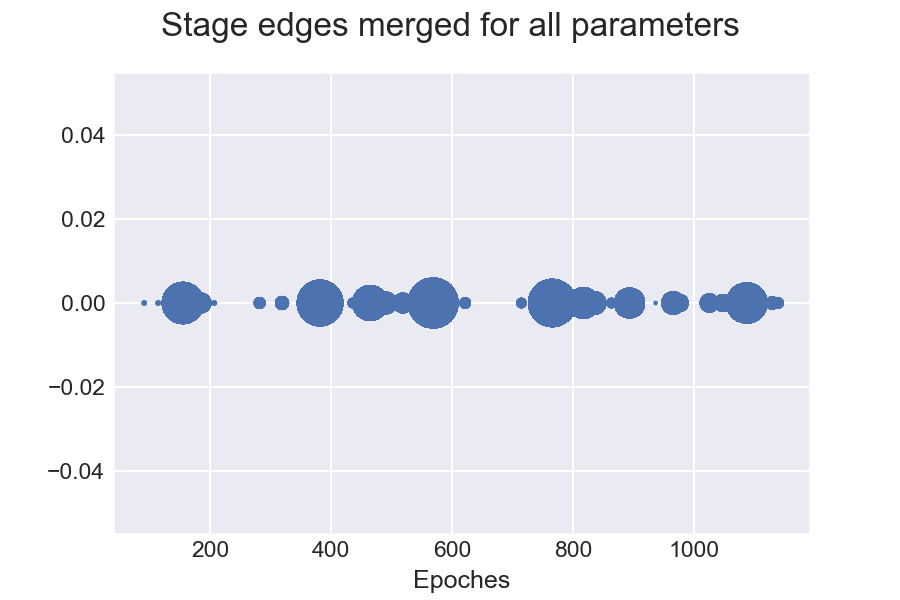

<IPython.core.display.Javascript object>


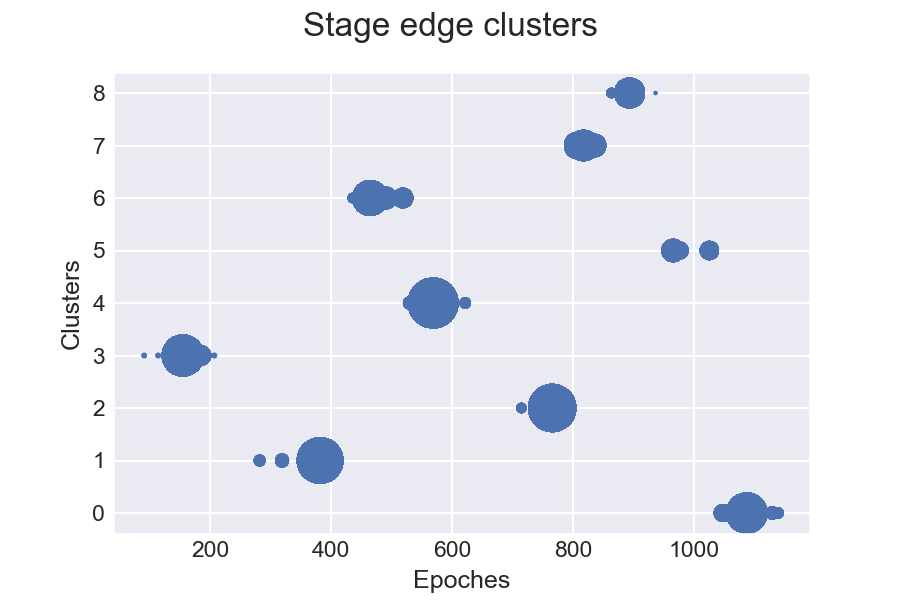

Text(0.5, 0.98, 'Stage edge clusters')

In [29]:
# Optimal number of clusters

n_stages = 10 # expert choise of result number of stages

st_len = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['St_len_min'].iloc[0]
k_nb = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['K_nb_max'].iloc[0]
n_cl = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['N_cl_max'].iloc[0]
#n_cl = 20

st_edges_result = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['St_edges'].iloc[0]
print(st_edges_result)

st_edges_all = []
st_edges_list = []
st_edges_list += (df_st_edges[(df_st_edges['Len_min']==st_len) & (df_st_edges['K_neighb']<=k_nb) &
                  (df_st_edges['N_clusters']<=n_cl)]['St_edges'].tolist())
for _st_edges in st_edges_list:
    st_edges_all += _st_edges[1:-1].tolist()
st_edges_all = sorted(st_edges_all)
df_st_edges_all = pd.DataFrame(st_edges_all)
#print(st_edges_all)
            
# Clustering stage edges
cl_name = 'kmeans_edges_'+str(n_stages-1)+'_'+str(st_len)+'_'+str(k_nb)
cluster_method, df_st_edge_metrics = cq.apply_cluster_method(data=df_st_edges_all, cl_method=KMeans, 
                                                            name=cl_name, df_metrics=df_st_edge_metrics, 
                                                            n_clusters=n_stages-1, random_state=0)
edg_labels_all = cluster_method.labels_

# Find mean, median, mode, std, confidence interval
df_st_edg_stats = pd.DataFrame(columns=['Cluster name', 'Median', 'Mean', 'Mode', 'Mode probability', 'Standard deviation', 
                                        'Median conf_interval_0.95', 'Cluster size'])
st_clusters = []
for _st in range(n_stages-1):
    st_clusters.append([st_edges_all[i] for i in np.where(cluster_method.labels_ == _st)[0]])
    mode, count = sp.stats.mode(st_clusters[_st])
    conf_int_median = spr.median_confidence_interval(pd.Series(st_clusters[_st]), cutoff=0.95)
    
    new_row = {'Cluster name': 'Edge cluster '+str(_st), 'Median': int(np.median(st_clusters[_st])), 'Mean': int(np.array(st_clusters[_st]).mean()), 'Mode': mode[0], 
               'Mode probability': count[0]/len(st_clusters[_st]), 'Standard deviation': int(np.array(st_clusters[_st]).std()), 
               'Median conf_interval_0.95': conf_int_median, 'Cluster size': len(st_clusters[_st])}
    df_st_edg_stats = df_st_edg_stats.append(new_row, ignore_index = True)

df_st_edg_stats = df_st_edg_stats.sort_values('Median', ignore_index=True)
display(df_st_edg_stats)
#dfi.export(df_st_edg_stats, "Stage edges clustering stats.png")
    
# Plotting st_edges_all
x = st_edges_all
y = [0]*len(x)
s = [1.5*x.count(x[i]) for i in range(len(x))]
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x,y, s=s)
ax.set(xlabel='Epoches')
ax.tick_params(axis='both', labelsize=11, direction='in')
fig.suptitle('Stage edges merged for all parameters', fontsize=16)
#plt.savefig('Stage edges merged.png')

# Plotting clusters    
x = st_edges_all
y = cluster_method.labels_
s = [1.5*x.count(x[i]) for i in range(len(x))]
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x,y, s=s)
ax.set(xlabel='Epoches', ylabel='Clusters')
ax.tick_params(axis='both', labelsize=11, direction='in')
fig.suptitle('Stage edge clusters', fontsize=16)
#plt.savefig('Stage edge clusters.png')


In [30]:
print(st_edges_init)
print(st_edges_result)
print(shuf_stages)

[0, 155, 382, 465, 519, 569, 766, 894, 983, 1082, 1180]
[0, 155, 382, 465, 569, 766, 818, 894, 968, 1088, 1180]
[6 4 0 9 1 3 2 8 7 5]


In [206]:
# Calculate stage distances & clustering quality metrics

# Main data
df_adj_st_metr = calc_stage_metr_noground(df_features, st_edges_result)
st_metr_silh = df_adj_st_metr['Silh'].to_numpy()
st_metr_calh = df_adj_st_metr['Cal-Har'].to_numpy()
st_metr_davb = df_adj_st_metr['Dav-Bold'].to_numpy()

st_dist_ward, st_dist_centr = spr.calc_stage_distances(df_features, st_edges_result)
df_adj_st_metr['Centr'] = st_dist_centr
df_adj_st_metr['Ward'] = st_dist_ward

# Initial data
df_adj_st_metr_init = calc_stage_metr_noground(df_features, st_edges_init)
st_metr_silh_init = df_adj_st_metr_init['Silh'].to_numpy()
st_metr_calh_init = df_adj_st_metr_init['Cal-Har'].to_numpy()
st_metr_davb_init = df_adj_st_metr_init['Dav-Bold'].to_numpy()

st_dist_ward_init, st_dist_centr_init = spr.calc_stage_distances(df_features, st_edges_init)
df_adj_st_metr_init['Centr'] = st_dist_centr_init
df_adj_st_metr_init['Ward'] = st_dist_ward_init


# Max distance values for plotting
st_dist_centr_max = np.max(np.concatenate((st_dist_centr, st_dist_centr_init)))
st_dist_ward_max = np.max(np.concatenate((st_dist_ward, st_dist_ward_init)))
st_metr_silh_max = np.max(np.concatenate((st_metr_silh, st_metr_silh_init)))
st_metr_calh_max = np.max(np.concatenate((st_metr_calh, st_metr_calh_init)))
st_metr_davb_max = np.max(np.concatenate((st_metr_davb, st_metr_davb_init)))

print('Centr:', round(st_dist_centr_max,2), ' Silh:', round(st_metr_silh_max,2), ' Davb:', round(st_metr_davb_max,2), 
      ' Ward:', round(st_dist_ward_max,2), ' Calh:', round(st_metr_calh_max,2))
display(df_adj_st_metr)
display(df_adj_st_metr_init)


Centr: 20.34  Silh: 0.24  Davb: 7.46  Ward: 21711.5  Calh: 72.75


,Stages,Silh,Cal-Har,Dav-Bold,Centr,Ward
0,St1_St2,0.02,6.52,7.32,4.53,"1,892.90"
1,St2_St3,0.13,30.15,2.87,12.41,"9,355.50"
2,St3_St4,0.04,9.64,3.44,9.86,"3,179.78"
3,St4_St5,0.12,18.33,2.30,14.09,"5,152.96"
4,St5_St6,0.09,16.49,2.98,11.87,"5,618.75"
5,St6_St7,0.01,6.54,4.65,7.21,"2,141.31"
6,St7_St8,0.02,2.06,7.46,4.28,564.86
7,St8_St9,0.22,47.56,1.70,19.74,"14,616.14"
8,St9_St10,0.03,5.43,5.59,6.47,"1,918.60"
9,St10_St11,0.04,10.99,4.16,8.35,"3,632.22"


,Stages,Silh,Cal-Har,Dav-Bold,Centr,Ward
0,St1_St2,0.02,6.52,7.32,4.53,"1,892.90"
1,St2_St3,0.13,30.15,2.87,12.41,"9,355.50"
2,St3_St4,0.04,9.64,3.44,9.86,"3,179.78"
3,St4_St5,0.12,18.33,2.30,14.09,"5,152.96"
4,St5_St6,0.09,16.49,2.98,11.87,"5,618.75"
5,St6_St7,0.02,10.77,5.08,6.62,"3,403.41"
6,St7_St8,0.24,72.75,1.65,20.34,"21,711.50"
7,St8_St9,0.03,5.16,5.81,6.21,"1,810.05"
8,St9_St10,0.04,9.40,4.41,7.98,"3,138.77"


[ 5773.91817476 13048.72004144 66481.10313049 86917.70515727
 46827.00096657 30811.66011841 24602.9062075   9721.5761059 ] [11.98410667 10.32090298 21.9828419  21.7048873  20.67414734 19.75053208
 16.67408966  9.64820716]
[55, 318, 254, 437, 431, 178, 190, 221, 242]
[380, 249, 437, 431, 178, 190, 219, 244]


<IPython.core.display.Javascript object>


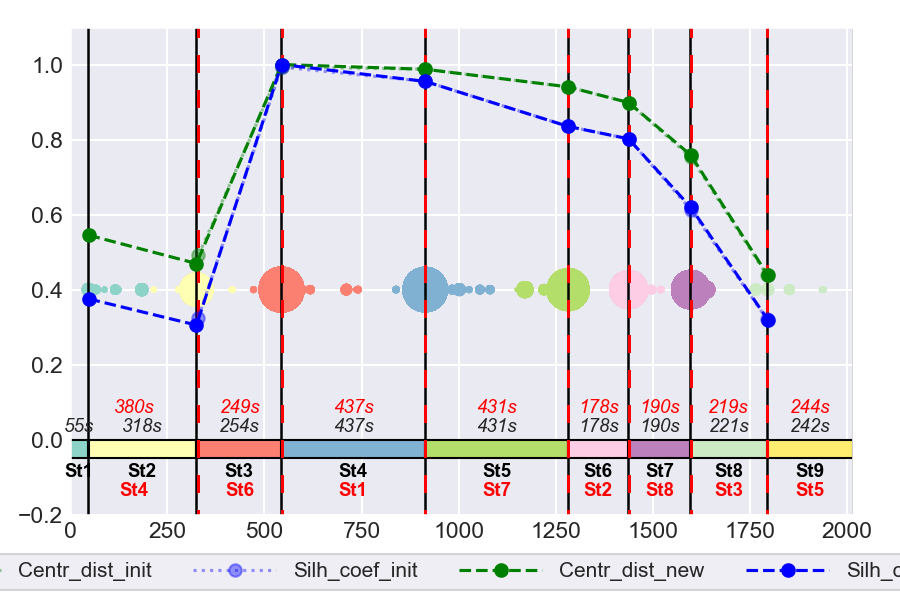

m08_stg shuffled stage boundaries.png


In [175]:
# Plotting stages, distances, silh between adjacent

df_features = df_ft_tot_pca_stg

# New stages
st_bands, st_labels = spr.form_stage_bands(st_edges_result)
n_stages = len(st_bands)
st_names = [_nm for (_,_,_nm) in st_bands]

# Initial stages
st_bands_init, st_labels_init = spr.form_stage_bands(st_edges_init)
n_stages_init = len(st_bands_init)

# Initial names of stages (before shuffling stages)
st_names_init = ['St'+str(n+1) for n in shuf_stages]

# Sorting cluster labels for st_edges_all
#edg_labels_all = cluster_method.labels_
labels_uq = sorted(set(edg_labels_all), key=list(edg_labels_all).index)
edg_labels_sort = []
for _cl in range(len(labels_uq)):
    edg_labels_sort += [_cl for i in np.where(edg_labels_all == labels_uq[_cl])[0]]

# Calculate stage distances & clustering quality metrics
st_dist_ward, st_dist_centr = spr.calc_stage_distances(df_features, st_edges_result)
print(st_dist_ward, st_dist_centr)

df_adj_st_metr = calc_stage_metr_noground(df_features, st_edges_result)
st_metr_silh = df_adj_st_metr['Silh'].to_numpy()
st_metr_calh = df_adj_st_metr['Cal-Har'].to_numpy()
st_metr_davb = df_adj_st_metr['Dav-Bold'].to_numpy()


# Max distance values for plotting
st_dist_centr_max = np.max(st_dist_centr)
st_metr_silh_max = np.max(st_metr_silh)
st_metr_calh_max = np.max(st_metr_calh)
#st_metr_davb_max = np.max(st_metr_davb)


# Getting time length of the stages

# New stage partition
cluster_events = epochs_filt_rr.events.copy()
cluster_events[:,2] = st_labels
time_bands = []
for i in range(n_stages):
    cl_samples = np.where(cluster_events[:,2] == i)[0]
    time_bands.append((cluster_events[cl_samples[0]][0], cluster_events[cl_samples[-1]][0], st_bands[i][2]))
st_time_len = [round((time_bands[i][1]-time_bands[i][0])/sampling_rate) for i in range(n_stages)]
print(st_time_len)

# Initial stage partition
cluster_events = epochs_filt_rr.events.copy()
cluster_events[:,2] = st_labels_init
time_bands = []
for _st in range(n_stages_init):
    cl_samples = np.where(cluster_events[:,2] == _st)[0]
    time_bands.append((cluster_events[cl_samples[0]][0], cluster_events[cl_samples[-1]][0], st_bands_init[_st][2]))
st_time_len_init = [round((time_bands[i][1]-time_bands[i][0])/sampling_rate) for i in range(n_stages_init)]
print(st_time_len_init)

    
# Plotting resulting stages
pal = plt.get_cmap('Set3')
#pal = plt.get_cmap('gist_ncar')

fig, ax = plt.subplots(figsize=(6,4))
for _st in range(n_stages):
    # Set x & y limits
    (ymin, ymax) = (-0.2, 1.1)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(0, n_samples)
    
    # Stages plot
    (x_start, x_end, st_name) = st_bands[_st]

    x = np.arange(x_start, x_end+1)
    y = np.full(len(x), 0)    
    event_label = 'N=%d' % (x_end-x_start+1)
    ax.add_patch(Rectangle((x_start, -0.05), x_end-x_start, 0.05, edgecolor = 'black', 
                           facecolor = pal(_st/(n_stages-1)), fill=True, lw=1)) # for 9 stages
                           #facecolor = pal(_st/n_stages), fill=True, lw=1)) # for 8,10 stages
    
    # Vertical lines (stage boundaries)
    ax.vlines(x_end, ymin=ymin, ymax=ymax, color='black', linewidth=1.2) # black lines
    #ax.vlines(x_end, ymin=ymin, ymax=ymax, color=pal(_st/(n_stages-1))) # colored lines
 
    # Scatter plot
    x_sc = [st_edges_all[i] for i in range(len(st_edges_all)) if edg_labels_sort[i]==_st]
    y_sc = np.full(len(x_sc), 0.4)
    s = [1.5*x_sc.count(x_sc[i]) for i in range(len(x_sc))]
    ax.scatter(x_sc, y_sc, s=s, color=pal(_st/(n_stages-1))) # for 9 stages
    #ax.scatter(x_sc, y_sc, s=s, color=pal(_st/n_stages)) # for 8,10 stages
    
    # Add text (st_name & st_length in sec)
    plt.text((x_start+x_end)/2, -0.1, st_names[_st], fontsize=9, fontweight='bold', 
             horizontalalignment='center', color='Black')
    plt.text((x_start+x_end)/2, 0.02, str(st_time_len[_st])+'s', fontsize=9, fontstyle='italic', horizontalalignment='center')

# Add information about initial stages
for _st in range(n_stages_init):
    (x_start_init, x_end_init, _) = st_bands_init[_st]

    # Vertical lines (initial stage boundaries)
    ax.vlines(st_edges_init[1:-1], ymin=ymin, ymax=ymax, color='red', linewidth=1.2, linestyles=(5,(7,7)))

    # Add text (st_name & st_length in sec)
    plt.text((x_start_init+x_end_init)/2, -0.15, st_names_init[_st], fontsize=9, fontweight='bold', 
             horizontalalignment='center', color='red')
    plt.text((x_start_init+x_end_init)/2, 0.07, str(st_time_len_init[_st])+'s', fontsize=9, fontstyle='italic',
             horizontalalignment='center', color='red')   
    
# Adjacent stage distances (Centroid) & Silh coef 

# Initial boundaries
x_dist_init = st_edges_init[1:-1]
y_centr_init = [_dist/st_dist_centr_max for _dist in st_dist_centr_init]
y_silh_init = [_dist/st_metr_silh_max for _dist in st_metr_silh_init]
#y_calh_init = [_dist/st_metr_calh_max for _dist in st_metr_calh_init]
#y_davb_init = [_dist/st_metr_davb_max for _dist in st_metr_davb_init]
    
ax.plot(x_dist_init, y_centr_init, linestyle='dotted', marker='o', color='green', alpha=0.4, label='Centr_dist_init')
ax.plot(x_dist_init, y_silh_init, linestyle='dotted', marker='o', color='blue', alpha=0.4, label='Silh_coef_init')
#ax.plot(x_dist, y_calh, linestyle='--', marker='o', color='orange', label='Cal-Har metric')
#ax.plot(x_dist, y_davb, linestyle='--', marker='o', color='red', label='Dav-Bold metric')

# Found boundaries
x_dist = st_edges_result[1:-1]
y_centr = [_dist/st_dist_centr_max for _dist in st_dist_centr]
y_silh = [_dist/st_metr_silh_max for _dist in st_metr_silh]
#y_calh = [_dist/st_metr_calh_max for _dist in st_metr_calh]
#y_davb = [_dist/st_metr_davb_max for _dist in st_metr_davb]
    
ax.plot(x_dist, y_centr, linestyle='--', marker='o', color='green', label='Centr_dist_new')
ax.plot(x_dist, y_silh, linestyle='--', marker='o', color='blue', label='Silh_coef_new')
#ax.plot(x_dist, y_calh, linestyle='--', marker='o', color='orange', label='Cal-Har metric')
#ax.plot(x_dist, y_davb, linestyle='--', marker='o', color='red', label='Dav-Bold metric')

#ax.set(xlabel='Epoches')
ax.tick_params(axis='both', labelsize=11, direction='in')
fig_name = subj_dir_name_stg + ' shuffled stage boundaries.png'
plt.savefig(fig_name)
print(fig_name)

plt.tight_layout(rect=[-0.01,0.05,1,1])
handles, labels = ax.get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=10, handlelength=4)# , mode='expand')


### Resulting stages

In [207]:
# Getting time length of the stages

st_bands, st_labels = spr.form_stage_bands(st_edges_result)
n_stages = len(st_bands)
st_names = [_nm for (_,_,_nm) in st_bands]

st_names =['Stage '+str(i+1) for i in range(n_stages)]
df_st_time_len = pd.DataFrame(columns=['Parameters']+st_names)

# New stage partition
cluster_events = epochs_filt_rr.events.copy()
cluster_events[:,2] = st_labels
time_bands = []
for i in range(n_stages):
    cl_samples = np.where(cluster_events[:,2] == i)[0]
    time_bands.append((cluster_events[cl_samples[0]][0], cluster_events[cl_samples[-1]][0], 'St'+str(i+1)))

# Start-end time
st_param_dict = dict([(st_names[i], (round(time_bands[i][0]/sampling_rate), round(time_bands[i][1]/sampling_rate))) 
                      for i in range(n_stages)])
new_row = {'Parameters': 'Start-end time, sec'}
new_row.update(st_param_dict)
df_st_time_len = df_st_time_len.append(new_row, ignore_index = True)

# Time length, sec
st_param_dict = dict([(st_names[i], str((time_bands[i][1]-time_bands[i][0])/sampling_rate)) for i in range(n_stages)])
new_row = {'Parameters': 'Time length, sec'}
new_row.update(st_param_dict)
df_st_time_len = df_st_time_len.append(new_row, ignore_index = True)

# Number of epochs, sec
st_param_dict = dict([(st_names[i], st_bands[i][1]-st_bands[i][0]+1) for i in range(n_stages)])
print(st_param_dict)
new_row = {'Parameters': 'Number of epochs'}
new_row.update(st_param_dict)
df_st_time_len = df_st_time_len.append(new_row, ignore_index = True)

print(time_bands)
print([((band[1]-band[0])/sampling_rate, band[2]) for band in time_bands])

display(df_st_time_len)    
df_st_time_len.to_excel(subj_dir_name_stg+'_result_'+str(n_stages)+' df_st_time_len.xlsx')


{'Stage 1': 155, 'Stage 2': 227, 'Stage 3': 83, 'Stage 4': 54, 'Stage 5': 50, 'Stage 6': 197, 'Stage 7': 52, 'Stage 8': 76, 'Stage 9': 74, 'Stage 10': 120, 'Stage 11': 92}
[(4250, 87250, 'St1'), (87750, 215750, 'St2'), (216250, 264250, 'St3'), (264750, 295750, 'St4'), (296250, 321750, 'St5'), (322250, 429250, 'St6'), (429750, 457250, 'St7'), (457750, 499250, 'St8'), (499750, 539750, 'St9'), (540250, 604250, 'St10'), (604750, 652250, 'St11')]
[(166.0, 'St1'), (256.0, 'St2'), (96.0, 'St3'), (62.0, 'St4'), (51.0, 'St5'), (214.0, 'St6'), (55.0, 'St7'), (83.0, 'St8'), (80.0, 'St9'), (128.0, 'St10'), (95.0, 'St11')]


,Parameters,Stage 1,Stage 2,Stage 3,Stage 4,Stage 5,Stage 6,Stage 7,Stage 8,Stage 9,Stage 10,Stage 11
0,"Start-end time, sec","(8, 174)","(176, 432)","(432, 528)","(530, 592)","(592, 644)","(644, 858)","(860, 914)","(916, 998)","(1000, 1080)","(1080, 1208)","(1210, 1304)"
1,"Time length, sec",166.0,256.0,96.0,62.0,51.0,214.0,55.0,83.0,80.0,128.0,95.0
2,Number of epochs,155,227,83,54,50,197,52,76,74,120,92


In [208]:
# DataFrame with stage distances (by adjacent pairs)

df_features = df_ft_tot_pca_stg

# Forming DataFrame with distance values    
st_dist_names = ['St'+str(i)+'_St'+str(i+1) for i in range(1, n_stages)]
df_st_dist_pairs = pd.DataFrame(columns=['Method'] + st_dist_names)
#display(df_st_dist_pairs)
 
# Ward distances
st_dist_ward_dict = dict([(st_dist_names[i], st_dist_ward[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Ward distance'}
new_row.update(st_dist_ward_dict)
df_st_dist_pairs = df_st_dist_pairs.append(new_row, ignore_index = True)

# Centroid distances
st_dist_cen_dict = dict([(st_dist_names[i], st_dist_centr[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Centroid distance'}
new_row.update(st_dist_cen_dict)
df_st_dist_pairs = df_st_dist_pairs.append(new_row, ignore_index = True)

# Silh metrics
st_metr_silh_dict = dict([(st_dist_names[i], st_metr_silh[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Silhouette Coefficient'}
new_row.update(st_metr_silh_dict)
df_st_dist_pairs = df_st_dist_pairs.append(new_row, ignore_index = True)

# Cal-Har metrics
st_metr_calh_dict = dict([(st_dist_names[i], st_metr_calh[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Calinski-Harabasz Index'}
new_row.update(st_metr_calh_dict)
df_st_dist_pairs = df_st_dist_pairs.append(new_row, ignore_index = True)

# Dav-Bold metrics
st_metr_davb_dict = dict([(st_dist_names[i], st_metr_davb[i]) for i in range(len(st_dist_names))])
new_row = {'Method': 'Davies-Bouldin Index'}
new_row.update(st_metr_davb_dict)
df_st_dist_pairs = df_st_dist_pairs.append(new_row, ignore_index = True)

display(df_st_dist_pairs)
df_st_dist_pairs.to_excel(subj_dir_name_stg+'_result_'+str(n_stages)+' df_st_dist_pairs.xlsx')

,Method,St1_St2,St2_St3,St3_St4,St4_St5,St5_St6,St6_St7,St7_St8,St8_St9,St9_St10,St10_St11
0,Ward distance,"1,892.90","9,355.50","3,179.78","5,152.96","5,618.75","2,141.31",564.86,"14,616.14","1,918.60","3,632.22"
1,Centroid distance,4.53,12.41,9.86,14.09,11.87,7.21,4.28,19.74,6.47,8.35
2,Silhouette Coefficient,0.02,0.13,0.04,0.12,0.09,0.01,0.02,0.22,0.03,0.04
3,Calinski-Harabasz Index,6.52,30.15,9.64,18.33,16.49,6.54,2.06,47.56,5.43,10.99
4,Davies-Bouldin Index,7.32,2.87,3.44,2.30,2.98,4.65,7.46,1.70,5.59,4.16


In [209]:
# DataFrame with averaged cluster distances & metrics

subj_name = subj_dir_name_stg+'_result_'+str(n_stages)

col_names = ['Subject', 'Ward dist', 'Centr dist', 'Silh Stage', 'Cal-Har Stage', 'Dav-Bold Stage', 
             'Silh Total', 'Cal-Har Total', 'Dav-Bold Total']
df_st_dist_total = pd.DataFrame(columns=col_names)

new_row = {'Subject': subj_name}
n_pair_metr = len(df_st_dist_pairs)
n_head_col = len(new_row)
n_add_col = len(col_names)-n_head_col-n_pair_metr 

st_metr_val = [df_st_dist_pairs[df_st_dist_pairs.columns[1:]].iloc[r].mean() for r in range(n_pair_metr)]
new_row_add1 = dict([(col_names[r+n_head_col], st_metr_val[r]) for r in range(n_pair_metr)])
new_row.update(new_row_add1)

df = cq.cluster_metrics_noground(subj_name, df_features, st_labels)
new_row_add2 = dict([(col_names[r+n_head_col+n_pair_metr], df[df.columns[r+1]].iloc[0]) for r in range(n_add_col)])
new_row.update(new_row_add2)

df_st_dist_total = df_st_dist_total.append(new_row, ignore_index = True)

display(df_st_dist_total)
df_st_dist_total.to_excel(subj_dir_name_stg+'_result_'+str(n_stages)+' df_st_dist_total.xlsx')


ValueError: Found input variables with inconsistent numbers of samples: [2017, 1180]

### Initial stages

In [161]:
# Getting time length of the stages

st_names =['Stage '+str(i+1) for i in range(n_stages_init)]
df_st_time_len_init = pd.DataFrame(columns=['Parameters']+st_names)

# New stage partition
cluster_events = epochs_filt_rr.events.copy()
cluster_events[:,2] = st_labels_init
time_bands = []
for i in range(n_stages_init):
    cl_samples = np.where(cluster_events[:,2] == i)[0]
    time_bands.append((cluster_events[cl_samples[0]][0], cluster_events[cl_samples[-1]][0], 'St'+str(i+1)))

# Start-end time
st_param_dict = dict([(st_names[i], (round(time_bands[i][0]/sampling_rate), round(time_bands[i][1]/sampling_rate))) 
                      for i in range(n_stages_init)])
new_row = {'Parameters': 'Start-end time, sec'}
new_row.update(st_param_dict)
df_st_time_len_init = df_st_time_len_init.append(new_row, ignore_index = True)

# Time length, sec
st_param_dict = dict([(st_names[i], str((time_bands[i][1]-time_bands[i][0])/sampling_rate)) for i in range(n_stages_init)])
new_row = {'Parameters': 'Time length, sec'}
new_row.update(st_param_dict)
df_st_time_len_init = df_st_time_len_init.append(new_row, ignore_index = True)

# Number of epochs, sec
st_param_dict = dict([(st_names[i], st_bands_init[i][1]-st_bands_init[i][0]+1) for i in range(n_stages_init)])
print(st_param_dict)
new_row = {'Parameters': 'Number of epochs'}
new_row.update(st_param_dict)
df_st_time_len_init = df_st_time_len_init.append(new_row, ignore_index = True)

print(time_bands)
print([((band[1]-band[0])/sampling_rate, band[2]) for band in time_bands])

display(df_st_time_len_init)    
df_st_time_len_init.to_excel(subj_dir_name_stg+'_init_'+str(n_stages_init)+' df_st_time_len.xlsx')


{'Stage 1': 330, 'Stage 2': 214, 'Stage 3': 370, 'Stage 4': 368, 'Stage 5': 156, 'Stage 6': 160, 'Stage 7': 196, 'Stage 8': 223}
[(5250, 195250, 'St1'), (195750, 320250, 'St2'), (320750, 539250, 'St3'), (539750, 755250, 'St4'), (755750, 844750, 'St5'), (845250, 940250, 'St6'), (940750, 1050250, 'St7'), (1050750, 1172750, 'St8')]
[(380.0, 'St1'), (249.0, 'St2'), (437.0, 'St3'), (431.0, 'St4'), (178.0, 'St5'), (190.0, 'St6'), (219.0, 'St7'), (244.0, 'St8')]


,Parameters,Stage 1,Stage 2,Stage 3,Stage 4,Stage 5,Stage 6,Stage 7,Stage 8
0,"Start-end time, sec","(10, 390)","(392, 640)","(642, 1078)","(1080, 1510)","(1512, 1690)","(1690, 1880)","(1882, 2100)","(2102, 2346)"
1,"Time length, sec",380.0,249.0,437.0,431.0,178.0,190.0,219.0,244.0
2,Number of epochs,330,214,370,368,156,160,196,223


In [162]:
# DataFrame with stage distances (by adjacent pairs)

df_features = df_ft_tot_pca_stg

# Forming DataFrame with distance values    
st_dist_names_init = ['St'+str(i)+'_St'+str(i+1) for i in range(1, n_stages_init)]
df_st_dist_pairs_init = pd.DataFrame(columns=['Method'] + st_dist_names_init)
#display(df_st_dist_pairs)
 
# Ward distances
st_dist_ward_dict = dict([(st_dist_names_init[i], st_dist_ward_init[i]) for i in range(len(st_dist_names_init))])
new_row = {'Method': 'Ward distance'}
new_row.update(st_dist_ward_dict)
df_st_dist_pairs_init = df_st_dist_pairs_init.append(new_row, ignore_index = True)

# Centroid distances
st_dist_cen_dict = dict([(st_dist_names_init[i], st_dist_centr_init[i]) for i in range(len(st_dist_names_init))])
new_row = {'Method': 'Centroid distance'}
new_row.update(st_dist_cen_dict)
df_st_dist_pairs_init = df_st_dist_pairs_init.append(new_row, ignore_index = True)

# Silh metrics
st_metr_silh_dict = dict([(st_dist_names_init[i], st_metr_silh_init[i]) for i in range(len(st_dist_names_init))])
new_row = {'Method': 'Silhouette Coefficient'}
new_row.update(st_metr_silh_dict)
df_st_dist_pairs_init = df_st_dist_pairs_init.append(new_row, ignore_index = True)

# Cal-Har metrics
st_metr_calh_dict = dict([(st_dist_names_init[i], st_metr_calh_init[i]) for i in range(len(st_dist_names_init))])
new_row = {'Method': 'Calinski-Harabasz Index'}
new_row.update(st_metr_calh_dict)
df_st_dist_pairs_init = df_st_dist_pairs_init.append(new_row, ignore_index = True)

# Dav-Bold metrics
st_metr_davb_dict = dict([(st_dist_names_init[i], st_metr_davb_init[i]) for i in range(len(st_dist_names_init))])
new_row = {'Method': 'Davies-Bouldin Index'}
new_row.update(st_metr_davb_dict)
df_st_dist_pairs_init = df_st_dist_pairs_init.append(new_row, ignore_index = True)

display(df_st_dist_pairs_init)
df_st_dist_pairs_init.to_excel(subj_dir_name_stg+'_init_'+str(n_stages_init)+' df_st_dist_pairs.xlsx')

,Method,St1_St2,St2_St3,St3_St4,St4_St5,St5_St6,St6_St7,St7_St8
0,Ward distance,"15,151.64","64,674.37","86,917.71","46,827.00","30,811.66","24,126.40","9,680.34"
1,Centroid distance,10.80,21.84,21.70,20.67,19.75,16.55,9.63
2,Silhouette Coefficient,0.08,0.25,0.24,0.21,0.20,0.16,0.08
3,Calinski-Harabasz Index,50.58,201.25,263.07,141.47,95.12,76.06,36.18
4,Davies-Bouldin Index,3.11,1.58,1.61,1.70,1.77,2.10,3.31


In [163]:
# DataFrame with averaged cluster distances & metrics

subj_name = subj_dir_name_stg+'_init_'+str(n_stages_init)

col_names = ['Subject', 'Ward dist', 'Centr dist', 'Silh Stage', 'Cal-Har Stage', 'Dav-Bold Stage', 
             'Silh Total', 'Cal-Har Total', 'Dav-Bold Total']
df_st_dist_total_init = pd.DataFrame(columns=col_names)

new_row = {'Subject': subj_name}
n_pair_metr = len(df_st_dist_pairs_init)
n_head_col = len(new_row)
n_add_col = len(col_names)-n_head_col-n_pair_metr 

st_metr_val = [df_st_dist_pairs_init[df_st_dist_pairs_init.columns[1:]].iloc[r].mean() for r in range(n_pair_metr)]
new_row_add1 = dict([(col_names[r+n_head_col], st_metr_val[r]) for r in range(n_pair_metr)])
new_row.update(new_row_add1)

df = cq.cluster_metrics_noground(subj_name, df_features, st_labels_init)
new_row_add2 = dict([(col_names[r+n_head_col+n_pair_metr], df[df.columns[r+1]].iloc[0]) for r in range(n_add_col)])
new_row.update(new_row_add2)

df_st_dist_total_init = df_st_dist_total_init.append(new_row, ignore_index = True)

display(df_st_dist_total_init)
df_st_dist_total_init.to_excel(subj_name+' df_st_dist_total.xlsx')


,Subject,Ward dist,Centr dist,Silh Stage,Cal-Har Stage,Dav-Bold Stage,Silh Total,Cal-Har Total,Dav-Bold Total
0,m08_stg_init_8,"39,741.30",17.28,0.18,123.39,2.17,0.04,140.95,3.41


# Saving data

In [179]:
# Saving shuffled stages data

# Shuffling order
np.savetxt(os.path.join(ft_dir_path, 'st_edges_result_stg.txt'), st_edges_result) # Resulting stage boundaries
np.savetxt(os.path.join(ft_dir_path, 'st_edges_init_stg.txt'), st_edges_init) # Initial stage boundaries
np.savetxt(os.path.join(ft_dir_path, 'shuffled_stages_order.txt'), shuf_stages)  # Shuffling order

# Clustering results for scatter plot
np.savetxt(os.path.join(ft_dir_path, 'st_edges_all_stg.txt'), st_edges_all) # Goint array of potential boundaries
np.savetxt(os.path.join(ft_dir_path, 'edg_labels_sort_stg.txt'), edg_labels_sort) # Cluster labels for goint array

print(ft_dir_path)

C:\Users\Lenovo\PycharmProjects\Tibet\features\m08
